## <font style="font-family:roboto;color:#455e6c"> Microstructure Evolution and workflows in computational materials science</font>  

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c"> IUC07 Beyond 3D: Tools for tracking spatiotemporal microstructure evolution </font> </br>
</div>

<table style="table-layout:fixed; width:100%; border-collapse:collapse;">
  <tr>
    <td style="width:25%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/kanapy_Logo.png" style="max-width:70%; height:auto;">
    </td>
    <td style="width:25%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/DAMASK_banner.png" style="max-width:70%; height:auto;">
    </td>
    <td style="width:25%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/Pyiron_workflow_Logo.png" style="max-width:70%; height:auto;">
    </td>
    <td style="width:25%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/Logo_NFDI-MatWerk.png" style="max-width:70%; height:auto;">
    </td>
  </tr>
</table>

### <font style="font-family:roboto;color:#455e6c"> Introduction </font>

A central challenge in microstructure modeling is that different simulation tools store and represent data in incompatible formats. This fragmentation makes it difficult to build end-to-end workflows where the output of one tool becomes the input of another. The problem becomes even more pronounced when tracking microstructure evolution, since most tools only record their own internal state and lack a common structure for storing time-dependent changes in grains, phases, and voxel fields.

Integrated tools used in this notebook
- Kanapy: generates synthetic 3D microstructures and performs statistical analysis
- DAMASK: performs mechanical simulations based on FFT solver with crystal-plasticity model
- Pyiron_workflow: constructs workflows as computational graphs

This notebook demonstrates how to construct and execute a complete microstructure-to-simulation workflow. The steps include:

- Reading and analysing an electron backscatter diffraction (EBSD) map
- Extracting statistical descriptors from the microstructure
- Generating a 3D microstructure statistically equivalent to the EBSD data
- Exporting the structure to DAMASK as a FAIR-DO object
- Running a cold-rolling simulation in DAMASK
- Capturing microstructure evolution by updating the FAIR-DO object at selected time steps
- Re-analysing the resulted microstructure with Kanapy and comparing it to the initial state
  
The concrete benefits of this workflow: 
The workflow creates a unified, automated chain from microstructure generation to mechanical simulation and post-processing. The FAIR-DO format ensures that results are reusable, traceable, and preserved over time. Automated data exchange removes manual file handling, and the modular node structure makes the workflow adaptable to a wide range of simulation tasks.

### <font style="font-family:roboto;color:#455e6c"> Setting up the core dependencies required for the workflow</font>

In [1]:
# =========================
# Standard library modules
# =========================
import logging
logging.disable(logging.WARNING)

import os
import io
import re
import json
import time
import shutil
import hashlib
import platform
import subprocess
from datetime import date
from pathlib import Path  # (deduped)
from typing import Union, Sequence, List, Dict, Any, Optional, Tuple
from collections import defaultdict

# =========================
# Third-party libraries
# =========================
import numpy as np
import numpy.ma as ma
from scipy.stats import lognorm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.transforms import Bbox
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import seaborn as sns
from copy import deepcopy
import h5py
import yaml                                                

from pyiron_workflow import Workflow
import kanapy as knpy
from orix.quaternion import Orientation
from orix.quaternion import Rotation
from orix.vector import Miller
import damask

# =========================
# Console formatting (ANSI)
# - Use OLD for bold, RESET to clear styles
# - Colors: CYAN / YELLOW / RED
# =========================
OLD   = "\033[1m"
CYAN  = "\033[1;36m"
YELLOW= "\033[1;33m"
RED   = "\033[1;31m"
RESET = "\033[0m"

### <font style="font-family:roboto;color:#455e6c"> From EBSD Map to 3D Microstructure Using Kanapy (Kanapy sub-workflow)</font>

The first part of this workflow prepares the microstructure that will later be used for simulation. We start from a 2D EBSD scan and use Kanapy to convert it into a simulation-ready 3D RVE (representative volume element).
This requires four core steps: locating the EBSD file, reading and interpreting the scan, reconstructing grains, and finally generating the 3D voxelized microstructure.
These steps ensure that the input structure is physically meaningful, statistically accurate, and compatible with downstream tools such as DAMASK or OpenPhase.
The goal is to standardize the transition from raw EBSD data to a fully defined 3D microstructure that fits seamlessly into a multi-software workflow.

<table style="table-layout:fixed; width:100%; border-collapse:collapse;">
  <tr>
    <!-- 1) EBSD map (Steps 1–3) -->
    <td style="width:20%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/EBSD.png" style="max-width:70%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Steps 1–3:<br>Locate, read &amp; analyse EBSD map
      </div>
    </td>
    <!-- 2) Arrow: generate 3D RVE -->
    <td style="width:10%; border:1px solid #ccc; text-align:center; padding:10px;">
      <div style="font-size:40px; line-height:1;">&#8594;</div>
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Generate 3D RVE
      </div>
    </td>
    <!-- 3) Synthetic microstructure (RVE) (Step 4) -->
    <td style="width:20%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/Synthetic microstrcuture.png" style="max-width:70%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Step 4:<br>3D synthetic microstructure (RVE)
      </div>
    </td>
    <!-- 4) Arrow: export as data object -->
    <td style="width:10%; border:1px solid #ccc; text-align:center; padding:10px;">
      <div style="font-size:40px; line-height:1;">&#8594;</div>
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Export as<br>data object
      </div>
    </td>
    <!-- 5) Data schema / FAIR Data Object (Step 5) -->
    <td style="width:20%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/data_structure.png" style="max-width:70%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Step 5:<br>FAIR data object (JSON schema)
      </div>
    </td>
  </tr>
</table>


**Step 1 — Locate and load the EBSD file**

This step identifies the EBSD map that will be used as the starting point for microstructure generation.
The workflow expects an EBSD file with the `.ang` extension and verifies that the file exists before proceeding.
This ensures the Kanapy pipeline always receives a valid EBSD input.

In [2]:
###############################################################################
# Step 1: Locate path to EBSD map
###############################################################################
@Workflow.wrap.as_function_node("path")
def locate_map_dir(file_extension: str, path: Union[str, Path, None]) -> str:
    """
    Find the first file with the given extension (e.g., '.ang') under `path`. 
    Returns the absolute path as a string.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 1: Locating EBSD file ...........................................................{RESET}")
    print("\n\n")

    # Ensure file_extension starts with a dot (e.g., ".ang")
    ext = file_extension if file_extension.startswith(".") else f".{file_extension}"
    ext = ext.lower()

    # Determine search root (do NOT convert to absolute; we keep things relative)
    search_root  = Path(path) if path is not None else Path.cwd()
    if not search_root.exists() or not search_root.is_dir():
        raise ValueError(f"The provided path '{search_root }' is not a valid directory.")

    found = None
    # Recursive walk; use os.path.join to construct paths
    for dirpath, _, filenames in os.walk(search_root ):
        for fname in filenames:
            if fname.lower().endswith(ext):
                found = os.path.join(dirpath, fname)
                break
        if found is not None:
            break

    if found is None:
        raise FileNotFoundError(f"No file with extension {ext} found in {search_root}")

    # Return relative path to the search root
    rel_path = os.path.relpath(found, start=search_root )

    print(f"{YELLOW}{OLD}Step 1 completed: Located file at {rel_path}{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return rel_path

**Step 2 — Read the EBSD map**

Here the EBSD file is parsed and converted into a structured object that Kanapy can work with.
The reader extracts orientations, phase information, and grain labels.
The goal is to turn a raw EBSD scan into a clean data container.

In [3]:
###############################################################################
# Step 2: Load and read EBSD map using Kanapy
###############################################################################
@Workflow.wrap.as_function_node("knpyObject")
def load_ebsd_map(file_path: str, show_plot: bool = False, pole_vector=(0,0,1)):
    """
    Load an EBSD map using Kanapy from `file_path`.
    Inputs:
      - file_path (str): Relative or absolute path to the EBSD file (e.g., .ang, .ctf).
      - show_plot (bool): If True, display the EBSD map visualization.
    Outputs:
      - ebsd (kanapy.EBSDmap): The loaded EBSD map object.
    """

    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 2: Loading EBSD map .............................................................{RESET}")
    print("\n\n")
    
    fp = Path(file_path)
    if not fp.exists():
        raise FileNotFoundError(f"{RED}{OLD}Invalid file path:{RESET} {file_path}. Please ensure the EBSD file exists.")

    ebsd = knpy.EBSDmap(str(fp), show_plot)

    print(f"{YELLOW}{OLD}Step 2 completed: EBSD map loaded from {fp}{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return ebsd

**Step 3 — Extract statistical descriptors from the EBSD map**

This step computes the microstructural statistics required for generating a 3D synthetic microstructure.
Kanapy needs distributions for grain size, aspect ratio, and grain-shape orientation (tilt angle). These statistical descriptors form the foundation for Kanapy's 3D reconstruction.
They ensure that the synthetic microstructure preserves the key statistical characteristics of the original EBSD map.

In [4]:
###############################################################################
# Step 3: Extract statistical parameters from EBSD map or a JSON file
###############################################################################
@Workflow.wrap.as_function_node("statisticalDescriptors")
def get_stats(source, NVoxels: int = 25, sizeRVE: int = 25, periodic: bool = True) -> Dict[str, Any]:
    """
    Extract microstructure statistics from `source`.
    Inputs:
      - source (str | Path | EBSDmap): JSON file with precomputed stats OR a Kanapy EBSDmap.
      - NVoxels (int): Number of voxels for stats/voxelization grid (default 25).
      - sizeRVE (int): Target RVE size for stats generation (default 25).
      - periodic (bool): Use periodic RVE (default True).
    Outputs:
      - ms_stats (dict): Microstructure stats (grain size, aspect ratio, orientations, etc.).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 3: Extracting microstructure statistics .........................................{RESET}")
    print("\n\n")
    
    # Case 1: If the source is a JSON file, import precomputed statistics
    if isinstance(source, (str, Path)):
        src = str(source)
        if not src.lower().endswith(".json"):
            raise ValueError("Only JSON files can be imported as statistical parameters.")
        if not os.path.isfile(src):
            raise FileNotFoundError(f"The specified JSON file '{src}' does not exist.")
        try:
            ms_stats = knpy.import_stats(src)
        except Exception as error:
            raise ValueError(f"Error reading JSON file '{src}': {error}")

    # Case 2: If the source is Kanapy EBSDmap-like object, compute statistics
    else:
         # Validation for expected attributes
         if not hasattr(source, "ms_data"):
            raise ValueError("Invalid EBSD map object: missing attribute 'ms_data'.")
             
         try:
             # Extract microstructural data from the EBSD map object
             
             ms_data = source.ms_data[0]
             # Normalize phase name: lowercase + underscores
             matname = ms_data["name"].lower().replace(" ", "_")
             
             gs_param = ms_data['gs_param']  # parameters for log-normal distribution of grain size
             ar_param = ms_data['ar_param']  # parameters for log-normal distribution of aspect ratios
             om_param = ms_data['om_param']  # parameters for normal distribution of ellipsoid tilt angles

             # Compute statistics using knpy
             ms_stats = knpy.set_stats(
                 gs_param, 
                 ar_param, 
                 om_param,
                 deq_min=3.0, deq_max=15.0, asp_min=0.95, asp_max=3.5,omega_min=0.0, omega_max=np.pi, 
                 voxels=NVoxels, size=sizeRVE,periodicity=periodic,
                 VF=ms_data["vf"], phasename=matname, phasenum=0
             )

             ms_stats["Data"] = {
                "grain_size": ms_data.get("gs_data"),
                "aspect_ratio": ms_data.get("ar_data"),
            }

         except (KeyError, IndexError, AttributeError) as exc:
             raise ValueError(f"EBSD map object is missing expected fields: {exc}")
             
    print(f"{YELLOW}{OLD}Step 3 completed: Microstructure statistics extracted................................{RESET}")
    print(f"{CYAN}{OLD}#####################################################################################{RESET}\n")
    print("\n\n")
    return ms_stats

**Step 4 — Generate the 3D synthetic microstructure**

This step uses the statistical descriptors to build a fully defined 3D representative volume element. Kanapy first creates a simulation box and fills it with ellipsoidal grains that follow the target grain-size, aspect-ratio, and orientation distributions. The grains are packed, voxelized into a regular 3D grid, and then assigned crystallographic orientations—either synthetic (Goss, Copper, random) or derived from a custom orientation distribution.
The result is a voxelized, physically consistent 3D microstructure ready for crystal-plasticity or phase-field simulations.

In [5]:
###############################################################################
# Step 4: create an RVE for simulating the microstructure of materials
###############################################################################
@Workflow.wrap.as_function_node("RVE")
def generate_rve(source: Dict[str, Any], ori, show_plots: bool = True) -> knpy.Microstructure:
    """
    Build a 3D RVE from microstructure stats in `source` and assign orientations.

    Inputs:
      - source (dict): Microstructure descriptor/stats (e.g., from knpy.set_stats()).
      - ori (str|object|None): 'goss' | 'copper' | 'random' OR a custom orientation object (e.g., ODF).

    Outputs:
      - ms (kanapy.Microstructure): The generated RVE (packed, voxelized, oriented).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 4: Generating RVE ...............................................................{RESET}")
    print("\n\n")
    
    # --- Minimal validation to avoid KeyErrors ---
    if not isinstance(source, dict):
        raise ValueError("`source` must be a dict (e.g., output of knpy.set_stats).")
    phase_dict = source.get("Phase") or {}
    material_name = phase_dict.get("Name")
    
    # 1) Create simulation box with ellipsoidal grains =================================================================
    ms = knpy.Microstructure(descriptor=source, name=f"{material_name}_RVE")
    ms.init_RVE()
    # Creates particle distribution (within the given lower and upper bounds)
    # inside simulation box (RVE) based on the data provided in the data file
    # ==================================================================================================================

    # 2) Perform particle packing ======================================================================================
    ms.pack()
    print("\n\n")
    if show_plots:
        ms.plot_ellipsoids()
    # Simulates grain packing in the box. Particles are initially downscaled
    # to avoid overlap and allow free movement. Collisions are handled during packing.
    # ==================================================================================================================

    # 3) Voxelize to 3D grid ===========================================================================================
    ms.voxelize()
    print("\n\n")
    if show_plots:
        ms.plot_voxels(sliced=True)
    # Converts the packed structure into a voxelated 3D mesh.
    #   Voxels inside grains are assigned to the grain phase, while others
    #   are filled according to a grain growth algorithm.
    # ==================================================================================================================
    print("\n\n")
    if show_plots:    
        ms.plot_stats_init(gs_data=source["Data"]["grain_size"], ar_data=source["Data"]["aspect_ratio"])
    
    # 4 - Assign orientations to grains ================================================================================
    if isinstance(ori, str):
        key = ori.lower().strip()
        if key == "goss":
            ang, omega, texture_desc = [0, 45, 0], 7.5, "unimodel"
        elif key == "copper":
            ang, omega, texture_desc = [90, 35, 45], 7.5, "unimodel"
        elif key == "random":
            ang, omega, texture_desc = None, None, "random"
        else:
            raise ValueError('Unsupported texture string in `ori`. Use "goss", "copper", or "random".')

        ms.generate_orientations(texture_desc, ang=ang, omega=omega, hist=None, Nbase=1000)
    else:
        # Custom orientation object (e.g., EBSD-derived ODF) or None
        ms.generate_orientations(ori) # downsample ODF of EBSD map to actual number of grains
    print("\n\n") 
    if show_plots:
        ms.plot_voxels(ori=True)  # plot voxelized grains in color code of IPF key
    # ==================================================================================================================
    print(f"{YELLOW}{OLD}Step 4 completed: RVE generated.......................................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return ms # Return the generated microstructure object

**Step 5 — Export the microstructure as a FAIR Data Object**

This step converts the generated RVE into a FAIR Data Object: a single JSON file that consolidates everything required for downstream simulation.
The function collects the voxelized microstructure, adds the user metadata, boundary conditions, phases, and units, checks the grain orientations, and then builds the complete FAIR Data Object that contains the following sections:
- User information
- System environment
- Job setup
- Property outputs
- microstructural data

The result is a standardized, interoperable data object that can be consumed reliably by other tools—such as DAMASK; the workflow remains transparent, reusable, and fully aligned with FAIR data principles.

In [6]:
###################################################################################
# Step 5: write the data json file containing all the data required the simulation
###################################################################################
@Workflow.wrap.as_function_node("dataFile")
def write_data( source: knpy.Microstructure, fileName: str | Path, user_metadata: dict, boundary_condition: dict, phases: list, units: dict) -> dict:
    """
    Build and save a single JSON data-schema file from a Kanapy Microstructure.
    Inputs:
      - source (kanapy.Microstructure): Voxelized RVE to serialize.
      - fileName (str|Path): Output JSON path (e.g., "_workflow/data_schema.json").
      - user_metadata (dict): Freeform metadata to embed.
      - boundary_condition (dict): BC block to embed.
      - phases (list): Phase descriptors for write_dataSchema.
      - units (dict): Units map, e.g. {"length":"um","stress":"MPa"}.
    Outputs:
      - data (dict): The full data dict that is written to disk.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 5: Exporting data ...............................................................{RESET}")
    print("\n\n")

    # 1) Validate basic inputs ---
    if not isinstance(user_metadata, dict):
        raise ValueError("user_metadata must be a dict")
    if not isinstance(boundary_condition, dict):
        raise ValueError("boundary_condition must be a dict")
    if not isinstance(phases, (list, tuple)):
        raise ValueError("phases must be a list/tuple")
    if not isinstance(units, dict):
        raise ValueError("units must be a dict")
        
    units_norm = {str(k).lower(): v for k, v in units.items()}
    length_unit = units_norm.get("length")
    if length_unit is None:
        length_unit = units.get("Length") or units.get("LENGTH")
    if length_unit is None:
        raise ValueError("units must contain a 'length' entry (e.g., {'length':'um'})")

    # 2) Build schema via Kanapy
    data = source.write_dataSchema(
        user_metadata=user_metadata,
        boundary_condition=boundary_condition,
        phases=phases,
        interactive=False,
        structured=True,
        length_unit=length_unit,
    )
    if not isinstance(data, dict) or not data:
        raise RuntimeError("write_dataSchema did not return a non-empty dict.")
    data["units"] = units # Add units to the data schema

    # 3) Locate grains robustly and validate orientations
    evo = data.get("microstructure_evolution")
    # If evo came back as a list, accept [ {...} ] as well
    if isinstance(evo, list):
        if len(evo) == 1 and isinstance(evo[0], dict):
            evo = evo[0]
        else:
            raise ValueError("Expected 'microstructure_evolution' as dict or single-element list of dict.")
    if not isinstance(evo, dict):
        raise ValueError("Missing or invalid 'microstructure_evolution' block (dict expected).")

    grains = evo.get("grains")
    if not isinstance(grains, list) or len(grains) == 0:
        raise ValueError("Missing or invalid 'grains' list inside 'microstructure_evolution'.")

    # Validate each grain has orientation [Phi1, Phi, Phi2]
    for i, g in enumerate(grains):
        if not isinstance(g, dict):
            raise ValueError(f"Grain at index {i} is not a dict: {type(g).__name__}")
        ori = g.get("orientation")
        if not (isinstance(ori, (list, tuple)) and len(ori) == 3):
            raise ValueError(f"Grain {i} has invalid 'orientation' (need [Phi1, Phi, Phi2]): {ori}")

    Phi1 = [g["orientation"][0] for g in grains]
    Phi  = [g["orientation"][1] for g in grains]
    Phi2 = [g["orientation"][2] for g in grains]
    n_gr = len(grains)

    # 4) Install Euler arrays in the Phase dict (phases[0].orientation.euler_angles) 
    p0 = data["phases"][0]
    p0.setdefault("orientation", {})
    p0["orientation"].setdefault("euler_angles", {})
    p0["orientation"]["euler_angles"]["Phi1"] = Phi1
    p0["orientation"]["euler_angles"]["Phi"]  = Phi
    p0["orientation"]["euler_angles"]["Phi2"] = Phi2
    p0["orientation"]["grain_count"] = n_gr

    # 5) Save JSON
    out_path = str(fileName)
    if not out_path.lower().endswith(".json"):
        out_path += ".json"
    out_path = os.path.join("data", os.path.basename(out_path))
    parent = os.path.dirname(out_path)
    if parent and not os.path.isdir(parent):
        os.makedirs(parent, exist_ok=True)

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    print("Saved to:", os.path.abspath(out_path))

    print(f"{YELLOW}{OLD}Step 5 completed: data saved in JSON file.............................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return data

### <font style="font-family:roboto;color:#455e6c">From 3D RVE to Simulation and Data updating Using DAMASK (DAMASK sub-workflow)</font>

In the second sub-workflow, the FAIR data object produced by Kanapy is taken as input to set up, run, and feed back a cold rolling simulation in DAMASK.

<table style="table-layout:fixed; width:100%; border-collapse:collapse;">
  <tr>
    <!-- 1) FAIR Data Object from Kanapy -->
    <td style="width:18%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/data_structure.png" style="max-width:100%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        FAIR data object<br>(from Kanapy sub-workflow)
      </div>
    </td>
    <!-- Arrow: Load into DAMASK -->
    <td style="width:6%; border:1px solid #ccc; text-align:center; padding:10px;">
      <div style="font-size:30px; line-height:1;">&#8594;</div>
      <div style="margin-top:6px; font-size:11px; color:#444;">
        Loaded by DAMASK
      </div>
    </td>
    <!-- 2) Microstructure evolution (Initial - Deformed - Last step) -->
    <td style="width:52%; border:1px solid #ccc; text-align:center; padding:10px;">
      <div style="display:flex; justify-content:space-between; align-items:center; gap:8px;">
        <div style="flex:1; text-align:center;">
          <div style="margin-bottom:4px; font-size:11px; color:#444;">
            time = 0
          </div>
          <img src="images/Initial microstrcutre copy.png" style="max-width:100%; height:auto;">
        </div>
        <div style="flex:1; text-align:center;">
          <div style="margin-bottom:4px; font-size:11px; color:#444;">
            time = 25
          </div>
          <img src="images/Deformed microstructure copy.png" style="max-width:100%; height:auto;">
        </div>
        <div style="flex:1; text-align:center;">
          <div style="margin-bottom:4px; font-size:11px; color:#444;">
            time = 50
          </div>
          <img src="images/Deformed microstructure at last step copy.png" style="max-width:100%; height:auto;">
        </div>
      </div>
      <!-- Caption under the three images -->
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Microstructure evolution (Initial → Deformed → Last Step)
      </div>
    </td>
    <!-- Arrow: Update FAIR Data Object -->
    <td style="width:6%; border:1px solid #ccc; text-align:center; padding:10px;">
      <div style="font-size:30px; line-height:1;">&#8594;</div>
      <div style="margin-top:6px; font-size:11px; color:#444;">
        Update<br>data object
      </div>
    </td>
    <!-- 3) Updated data object including evolution -->
    <td style="width:18%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/update data file.png" style="max-width:100%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        FAIR data object updated<br>with microstructure evolution
      </div>
    </td>
  </tr>
</table>

**Step 6 – Prepare DAMASK input files**

The function load_to_damask reads the data (FAIR data object) and automatically builds the three core DAMASK inputs:
a structured FFT grid (grid.vti), 
a phase-consistent material file (material.yaml), 
and a loadcase file (load.yaml) with user-defined deformation history, time stepping, and requested outputs.
Material parameters, constitutive models, elastic constants, and plasticity settings are all derived from

In [7]:
###############################################################################
# Step 6: Writing grid, material, and load files to start a DAMASK simulation
###############################################################################
@Workflow.wrap.as_function_node("grid", "material", "load")
def load_to_damask(
    source: dict,
    load: List[List[Union[float, str]]] | List[List[List[Union[float, str]]]],
    grid_out: Union[str, Path] = "grid.vti",
    material_out: Union[str, Path] = "material.yaml",
    load_out: Union[str, Path] = "load.yaml",
    t_list: Sequence[float] = (50.0,),     # total time per step
    N_list: Sequence[int]   = (100,),       # number of increments per step
    f_out_list: Sequence[int] = (1,),       # write results every f_out increments
    f_restart_list: Sequence[int] = (50,),       # write results every f_out increments
    outputs: Sequence[str] = ("F", "P", "F_p", "F_e", "L_p", "O"),
):
    """
    Build DAMASK grid/material/load files from a schema-like `source`.

    Inputs:
      - source (dict): Data schema used by DAMASK helpers (kanapy→DAMASK).
      - load (3x3 or list of 3x3): Deformation-rate matrices per step (numbers or 'x').
      - grid_out/material_out/load_out (str|Path): Output filenames (relative or absolute).
      - t_list, N_list, f_out_list: Per-step times, increments, and output stride.
      - outputs (list[str]): Mechanical outputs to request.

    Outputs:
      - (grid_path, material_path, load_path) as strings (relative to CWD if given that way).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 6: Building grid/material/load from JSON ........................................{RESET}")
    print("\n\n")
    
    grid_out = os.path.join("damaskfiles", grid_out)
    material_out = os.path.join("damaskfiles", material_out)
    load_out = os.path.join("damaskfiles", load_out)
    for fp in (grid_out, material_out, load_out):
        out_dir = os.path.dirname(str(fp))
        if out_dir and not os.path.isdir(out_dir):
            os.makedirs(out_dir, exist_ok=True)
    
    # 1) Basic validation of input JSON ----------------
    if not isinstance(source, dict):
        raise TypeError("`source` must be a dict.")
    if "phases" not in source or not isinstance(source["phases"], list) or len(source["phases"]) == 0:
        raise KeyError("Missing or empty 'phases' array in source.")
    phases_in = source["phases"]

    # 2) Validate step schedules ----------------
    if not (len(t_list) == len(N_list) == len(f_out_list)):
        raise ValueError("t_list, N_list, and f_out_list must have the same length.")
    num_steps = len(t_list)

    for i, (t, N, f) in enumerate(zip(t_list, N_list, f_out_list), start=1):
        if not (isinstance(t, (int, float)) and t > 0):
            raise ValueError(f"Step {i}: t must be > 0 (got {t}).")
        if not (isinstance(N, int) and N >= 1):
            raise ValueError(f"Step {i}: N must be an integer >= 1 (got {N}).")
        if not (isinstance(f, int) and 1 <= f <= N):
            raise ValueError(f"Step {i}: f_out must be an integer in [1, N] (got {f}).")

    # 3) Normalize `load` per your rule ----------------
    # Check if `load` is a single 3x3 matrix
    is_single_3x3 = (
        isinstance(load, list) and
        len(load) == 3 and all(isinstance(row, list) and len(row) == 3 for row in load))
    
    if num_steps == 1:
        # Allow either a 3x3 or a list with one 3x3
        if is_single_3x3:
            loads_per_step = [load]  # wrap single 3x3 as a list of length 1
        else:
            # Is it a list with one 3x3?
            is_list_with_one_3x3 = (
                isinstance(load, list) and
                len(load) == 1 and
                isinstance(load[0], list) and
                len(load[0]) == 3 and
                all(isinstance(r, list) and len(r) == 3 for r in load[0])
            )
            if not is_list_with_one_3x3:
                raise ValueError(
                    "For one step: `load` must be a 3x3 matrix or a list containing one 3x3 matrix."
                )
            loads_per_step = load  # already [3x3]
    else:
        # For multiple steps: require list of length num_steps, each entry a 3x3
        is_list_of_3x3 = (
            isinstance(load, list) and
            len(load) == num_steps and
            all(
                isinstance(m, list) and len(m) == 3 and
                all(isinstance(r, list) and len(r) == 3 for r in m)
                for m in load
            )
        )
        if not is_list_of_3x3:
            raise ValueError(
                f"For {num_steps} steps: `load` must be a list of {num_steps} items, each a 3x3 matrix. "
                "Even if identical, repeat the 3x3 per step."
            )
        loads_per_step = load

    # 4) Geometry ----------------
    grid = damask.GeomGrid.load_kanapy(source)
    grid.save(str(grid_out))
    print(grid)
    print("\n\n")
    # 5) Material (build all phases from `source['phases']`) ----------------
    cfg = damask.ConfigMaterial.load_kanapy(source)
    print(cfg)
    print("\n\n")
    phase_dict: Dict[str, Any] = {}
    

    for p in phases_in:
        pid = p.get("phase_id")
        phase_key = f"{pid}" if pid is not None else None 
        if phase_key is None:
            raise ValueError("Phase entry lacks 'phase_id'.")

        cm = p.get("constitutive_model")
        if not isinstance(cm, dict):
            raise KeyError(f"Phase '{phase_key}' missing 'constitutive_model'.")

        elastic = cm.get("elastic_parameters")
        if not isinstance(elastic, dict):
            raise KeyError(f"Phase '{phase_key}' missing 'elastic_parameters'.")
        for k in ("C11", "C12", "C44"):
            if k not in elastic:
                raise KeyError(f"Phase '{phase_key}' missing elastic parameter '{k}'.")

        # Accept Pa as-is; convert 100..1000 (GPa) → Pa
        C11 = float(elastic["C11"])
        C12 = float(elastic["C12"])
        C44 = float(elastic["C44"])
        
        plastic_params = cm.get("plastic_parameters")
        plasticity_type = cm.get("plastic_model_name")

        if not plasticity_type:
            raise KeyError(f"Phase '{phase_key}' missing 'plastic_model_name'.")
        if not isinstance(plastic_params, dict):
            raise KeyError(f"Phase '{phase_key}' missing 'plastic_parameters' dictionary.")
    
        plastic_block = {"type": plasticity_type}
        plastic_block.update(plastic_params)

        phase_dict[phase_key] = {
            "lattice": "cF",  # FCC for Al; change if your JSON provides lattice info
            "mechanical": {
                "output": list(outputs),
                "elastic": {"type": "Hooke", "C_11": C11, "C_12": C12, "C_44": C44},
                "plastic": plastic_block,
            }
        }

    cfg.update(phase=phase_dict)
    if hasattr(cfg, "is_complete") and not cfg.is_complete:
        raise ValueError("material.yaml is not complete after update (check phases/mechanics).")
    cfg.save(str(material_out))

    # 6) Loadcase (user-defined number of steps) ----------------
    loadsteps = []
    for i in range(num_steps):
        dot_F = loads_per_step[i]
        # P-mask: set 'x' entries to 0;and set numeric entries to 'x'
        P = [[0 if (isinstance(v, str) and v.strip().lower() == 'x') else 'x' for v in row]
     for row in dot_F]

        loadsteps.append({
            "boundary_conditions": {"mechanical": {"dot_F": dot_F, "P": P}},
            "discretization": {"t": float(t_list[i]), "N": int(N_list[i])},
            "f_out": int(f_out_list[i]), "f_restart": int(f_restart_list[i]),
        })

    lc = damask.LoadcaseGrid(
        solver={"mechanical": "spectral_basic"},
        loadstep=loadsteps,
    )
    lc.save(str(load_out))
    grid = str(Path(grid_out).resolve())
    material = str(Path(material_out).resolve())
    loadcase = str(Path(load_out).resolve()) 
    print(f"{YELLOW}{OLD}Step 6 completed: Files are written..................................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n") 
    return grid, material, loadcase
        

**Step 7 – Run the DAMASK simulation**

The function run_damask calls DAMASK_grid with the generated grid, material, and load files.
It validates the input paths, launches the spectral solver, logs the run, and returns the path to the resulting HDF5 file that contains the full field data over all increments.

In [8]:
###############################################################################
# Step 7: Running DAMASK simulations using the FFT grid (spectral) solver
###############################################################################
@Workflow.wrap.as_function_node("results")
def run_damask( grid_file: Union[str, Path], material_file: Union[str, Path], load_file: Union[str, Path] ) -> str:
    """
    Run DAMASK_grid with the provided grid/material/load files.

    Inputs:
      - grid_file (str|Path): Path to grid (.vti).
      - material_file (str|Path): Path to material (.yaml).
      - load_file (str|Path): Path to loadcase (.yaml).

    Outputs:
      - fn_hdf (str): Path to the produced HDF5 results file.
    """
    print(f"{CYAN}{OLD}#########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 7: Start Simulation ..............................................................{RESET}")
    print("\n\n")
    
    # 1) Resolve & validate input paths -------------------------------------------------
    # Use Path for robust path manipulations and clearer file name handling.
    fn_geometry = Path(grid_file)
    fn_material = Path(material_file)
    fn_load     = Path(load_file)

    if not fn_geometry.is_file():
        raise FileNotFoundError(f"Geometry file not found: {fn_geometry}")
    if not fn_material.is_file():
        raise FileNotFoundError(f"Material file not found: {fn_material}")
    if not fn_load.is_file():
        raise FileNotFoundError(f"Load file not found: {fn_load}")

    # Ensure the DAMASK solver is available on PATH.
    if shutil.which("DAMASK_grid") is None:
        raise RuntimeError("DAMASK_grid not found in PATH. Activate your DAMASK env or add it to PATH.")

    damask_dir = fn_geometry.parent
    damask_dir = str(damask_dir)                           
    os.makedirs(damask_dir, exist_ok=True)                 
    log_path = os.path.join(damask_dir, "run.log")

    # 2) Build the command --------------------------------------------------------------
    # Prefer passing a list to Popen over shell=True to avoid shell quirks and quoting issues.
    cmd = [
        "DAMASK_grid",
        "-g", str(fn_geometry),
        "-l", str(fn_load),
        "-m", str(fn_material),
    ]
    print("Running:", " ".join(cmd))

    # 3) Launch process & stream output -------------------------------------------------
    # Merge stderr into stdout so we can stream everything in order and avoid potential deadlocks.
    # text=True gives us str lines; bufsize=1 enables line-buffered streaming.
    with open(log_path, "a", encoding="utf-8") as log:     
        print("Running:", " ".join(cmd), file=log)
        
        process = subprocess.run(
            cmd,
            stdout=log,
            stderr=subprocess.STDOUT,
            text=True,
            check=False,
            cwd=damask_dir,
        )

    # Print solver output live (useful inside notebooks / CI logs).
    #for line in process.stdout:
        #print(line, end="")

    # Wait for completion and get return code.
    #process.wait()

    # 4) Post-process result ------------------------------------------------------------
    if process.returncode != 0:
        print("Error during simulation (non-zero return code).")
        fn_hdf = False  # keep your original sentinel for failure
    else:
        print("Simulation completed successfully.")
        # Many DAMASK runs name the HDF5 as "<geom>_<load>_<mat>.hdf5".
        # Use Path.stem to strip extensions robustly (e.g., ".vti", ".yaml").
        out_name = f"{fn_geometry.stem}_{fn_load.stem}_{fn_material.stem}.hdf5"
        fn_hdf = out_name  # keep as string to match your existing downstream expectations
        fn_hdf = os.path.join(damask_dir, out_name)
        
    print(f"{YELLOW}{OLD}Step 7 completed: Simulation finished ..................................................{RESET}")
    print(f"{CYAN}{OLD}########################################################################################{RESET}\n")
    print("\n\n")
    return fn_hdf

**Step 8 – Post-process simulation results**

The function post_processing opens the HDF5 result and enriches it with derived quantities (Cauchy stress, logarithmic strain, von Mises stresses, and IPF colors).
It exports VTK files for visualization, computes the RVE-average stress–strain response as well as per-grain curves, saves the plots, and writes the averaged stress–strain data back into a JSON file as part of updating the property part of the data file.
This step links the DAMASK simulation back to a structured data representation.

In [9]:
###############################################################################
# Step 8: Post-processing after
###############################################################################
@Workflow.wrap.as_function_node("updatedResults")
def post_processing(results: str, json_path: Union[str, Path], grid_file: Union[str, Path]):
    """
    Post-process a DAMASK HDF5 result and its grid.

    Inputs:
      - results (str|Path): Path to the .hdf5 output from DAMASK.
      - json_path (str|Path): Target JSON filename (bare name or full/relative path).
      - grid_file (str|Path): Path to the .vti grid file.

    Outputs:
       - Path to the updated JSON file.  
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 8: Start postprocessing .........................................................{RESET}")
    print("\n\n")

    # 1) Locate result file ----------------
    fn_hdf = str(results)
    if not os.path.exists(fn_hdf):
        raise FileNotFoundError(f"Result file not found: {fn_hdf}")

    # 2) Load results ----------------------
    result = damask.Result(fn_hdf)

    try:
        result.add_stress_Cauchy("P", "F")                         # -> 'sigma'
        result.add_strain("F")                                # -> 'epsilon_V^0.0(F)' (log strain) strain tensor of F
        result.add_equivalent_Mises('sigma')             # -> 'sigma_vM'
        result.add_equivalent_Mises('epsilon_V^0.0(F)')  # -> 'epsilon_vM'
        result.add_IPF_color(l = [1,0,0], q = 'O')       # -> RGB color tuple of inverse pole figure (IPF) color
    except ValueError as e:
        print(f"Skipping variable addition: {e}")

    # Optional quick viewer for the last increment (ignore if not available in headless runs)
    try:
        result.view(increments=-1)
    except Exception as e:
        print(f"Viewer skipped: {e}")

    # 3) Export VTK for ParaView ----------
    damask_dir = os.path.dirname(str(grid_file))
    vtk_dir = os.path.join(damask_dir, "vtk")
    os.makedirs(vtk_dir, exist_ok=True)
    try:
        result.export_VTK(target_dir=vtk_dir)
        print("Exported VTK to:", vtk_dir)
    except Exception as e:
        print(f"VTK export skipped: {e}")

    # 4) Load grid  ------------
    grid = damask.GeomGrid.load(grid_file)

    # Precompute useful arrays
    mat_flat = grid.material.flatten(order='F')
    grain_ids = np.unique(mat_flat)
    n_grains = int(grain_ids.max()) + 1 if grain_ids.size else 0

    # ------------------------------------------------------------------------------
    # 5) Average stress–strain curve
    # ------------------------------------------------------------------------------
    
    cumulative_data = [] 
        
    for inc in result.get(['epsilon_V^0.0(F)', 'P']).values():
        P = inc['P']
        epsilon = inc['epsilon_V^0.0(F)']

        # loop grains, average P11 per grain
        for g in range(n_grains):  
            points = (mat_flat == g)
            if np.sum(points) == 0:  
                continue
                    
            P_11 = P[points, 0, 0].flatten()
            epsilon_11 = np.full_like(P_11, epsilon[:, 0, 0].mean())  
            grain_data = pd.DataFrame({'epsilon_11': epsilon_11, 'P_11': P_11})
            cumulative_data.append(grain_data)  # Append data to list
        
    cumulative_data = pd.concat(cumulative_data, ignore_index=True)  # Convert to DataFrame once
    average_data = cumulative_data.groupby('epsilon_11', as_index=False).mean()

    # --------------------------
    # 5b) Update the JSON file (store curves multiplied by -1)
    # --------------------------
    json_path = Path(os.path.join("data", str(json_path)))
    os.makedirs(os.path.dirname(str(json_path)), exist_ok=True)
    try:
        if json_path.exists():
            data = json.loads(json_path.read_text(encoding='utf-8'))
        else:
            data = {}
    except Exception as e:
        print(f"JSON read failed ({e}); starting from empty object.")
        data = {}
    
    # Multiply by -1 before storing
    neg_strain = (-average_data['epsilon_11'].to_numpy()).astype(float).tolist()
    neg_stress = (-average_data['P_11'].to_numpy()).astype(float).tolist()

    data["strain_11"] = neg_strain
    data["stress_11"] = neg_stress

    json_path.write_text(json.dumps(data, indent=2), encoding='utf-8')
    print(f"Updated JSON with average curve: {json_path}")

    
    # Plot results
    avg_plot = average_data.copy()
    
    avg_plot['epsilon_11'] *= -1.0
    avg_plot['P_11']       *= -1.0
    
    sns.lineplot(x='epsilon_11', y='P_11', data=avg_plot, marker='o')
    plt.xlabel("Average ε11")
    plt.ylabel("Average P11")
    plt.title("Average Stress–Strain Response Across All Grains")
    os.makedirs(os.path.join("figures"), exist_ok=True)
    figure_path_1 = os.path.join("figures", "stress_strain.png")
    plt.savefig(figure_path_1, dpi=300, bbox_inches='tight')
    plt.show()

    # ------------------------------------------------------------------------------
    # 6) Per-grain stress–strain curves for a few grains (0..3)
    #    - x: RVE-average ε_11 per increment
    #    - y: grain-average P_11 per increment
    # ------------------------------------------------------------------------------
    # Run the function
    p0 = data["phases"][0]
    n_gr = p0["orientation"]["grain_count"]
    grains = list(range(n_gr))
    grains_data: Dict[int, pd.DataFrame] = {g: pd.DataFrame() for g in grains}
    
    for inc in result.get(['epsilon_V^0.0(F)','P']).values():
        P = inc['P']
        epsilon = inc['epsilon_V^0.0(F)']
        
        for g in grains:
            points = (mat_flat == g)
            if not np.any(points):
                continue
            P_11 = P[points,0,0].flatten()
            eps11 = np.broadcast_to(np.average(epsilon[:,0,0]), P_11.shape)
            grains_data[g] = pd.concat(
                (grains_data[g], pd.DataFrame({'epsilon_11': eps11, 'P_11': P_11})),
                ignore_index=True)
            
    plot = None
    for g in grains:
        _df = grains_data[g].copy()
        if _df.empty:
            continue
        _df['epsilon_11'] = -_df['epsilon_11']
        _df['P_11']       = -_df['P_11']
        plot = sns.lineplot(y='P_11', x='epsilon_11', data=_df)

    if plot is not None:
        fig = plot.get_figure()
        plt.xlabel("ε11")
        plt.ylabel("P11")
        plt.title("Per-grain Stress–Strain Response")
        figure_path_2 = os.path.join("figures", "stress_strain_per_grain.png")
        plt.savefig(figure_path_2, dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No per-grain data to plot.")
        
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 8 completed: End of postprocessing ........................................................{RESET}")
    print("\n\n")
    return json_path


**Step 9 – Update the FAIR data object with microstructure evolution**

The function update_microstructure_data takes the original JSON and the DAMASK HDF5 file and appends new microstructure_evolution snapshots.
For selected increments, it maps DAMASK’s voxel data back to the JSON voxel layout, updating per-voxel orientations, centroid positions (by adding displacements), and voxel volumes via det(F).
It then recomputes grain volumes and grain-average orientations and attaches physical time stamps.
The output is an updated FAIR data object that now contains not only initial microstructure and properties but also the time-resolved microstructure evolution driven by the DAMASK simulation.

In [10]:
###############################################################################
# Step 9: Updating data schema
###############################################################################
@Workflow.wrap.as_function_node
def update_microstructure_data(
    json_path: Union[str, Path],
    hdf5_path: Union[str, Path],
    n_extract: int = 2,
    *,
    degrees: bool = False,
    time_s: float | Sequence[float] | None = None,   # <-- user-provided time(s)
    out_path: str | Path | None = None,
) -> Path:
    """
    Append n_extract new microstructure_evolution snapshots to a Kanapy-style JSON by
    pulling per-voxel orientations from DAMASK increments.

    - Keeps JSON voxel ordering (C-order list), 1-based voxel_id and voxel_index as-is.
    - Uses 1-based voxel_index [i,j,k] to compute the Fortran-order linear index for DAMASK
      flat arrays, then updates each voxel's `orientation` (Euler Bunge), centroid, and volume.
    - Then updates grain-level `grain_volume` (sum of voxel volumes) and `orientation`   
      (unweighted circular mean of voxel Euler angles per grain).                        
    - Increments chosen as:
        n_extract == 1 → only the last increment
        n_extract  > 1 → evenly spaced interior increments (excluding 0) plus the last
    - No time is read from DAMASK. If you pass `time_s`:
        * float → applied to all appended snapshots
        * sequence[float] → must match number of appended snapshots
        * None → no `time` field is written
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 9: updating json data file ......................................................{RESET}")
    print("\n\n")
    json_path = Path(json_path)
    hdf5_path = Path(hdf5_path)
    if out_path is None:
        out_path = json_path.with_name(json_path.stem + "__updated.json")
    out_path = Path(out_path)

    # -------- JSON load & checks --------
    data = json.loads(json_path.read_text())
    if "microstructure_evolution" not in data or not data["microstructure_evolution"]:
        raise ValueError("JSON missing 'microstructure_evolution[0]'.")
    evo0 = data["microstructure_evolution"][0]
    voxels = evo0.get("voxels")
    if not isinstance(voxels, list) or not voxels:
        raise ValueError("JSON missing 'microstructure_evolution[0].voxels' list.")

    # -------- Grid sizes from size/spacing --------
    size    = np.asarray(data["RVE_size"], float)
    spacing = np.asarray(data["discretization_unit_size"], float)
    cells_f = size / spacing
    cells   = np.rint(cells_f).astype(int)
    if not np.allclose(cells_f, cells, atol=0, rtol=0):
        raise ValueError(f"Non-integer voxel counts from size/spacing: {cells_f}")
    Nx, Ny, Nz = map(int, cells.tolist())
    N_calc = int(Nx * Ny * Nz)
    N_json = int(data.get("discretization_count", N_calc))
    if N_calc != N_json:
        raise ValueError(f"discretization_count mismatch: JSON={N_json} vs computed={N_calc}")
    if len(voxels) != N_calc:
        raise ValueError(f"voxels list length ({len(voxels)}) != Nx*Ny*Nz ({N_calc})")

    # -------- Open DAMASK & pick increments --------
    result = damask.Result(str(hdf5_path))
    if not result.increments:
        raise ValueError("No increments found in DAMASK result.")
    inc_ids: List[str] = result.increments
    last_idx = len(inc_ids) - 1
    
    if n_extract <= 1:
        pick_idxs = [last_idx]                                                 
    else:
        k = min(int(n_extract), last_idx)                                      
        base = np.linspace(last_idx / k, last_idx, num=k)                   
        pick_idxs = np.ceil(base).astype(int).tolist()                      
        pick_idxs = [min(max(1, i), last_idx) for i in pick_idxs]               
        if pick_idxs[-1] != last_idx:
            pick_idxs[-1] = last_idx                                          
        pick_idxs = sorted(set(pick_idxs))                                 
    
    selected = [inc_ids[i] for i in pick_idxs]

    # Normalize time_s input to a list aligned with `selected`
    time_values: List[float] | None
    if time_s is None:
        time_values = None
    elif isinstance(time_s, (int, float)):
        T = float(time_s)                                    # total duration      
        denom = max(1, last_idx)                             # avoid div by zero    
        time_values = [T * (i / denom) for i in pick_idxs]   # scale by increment   
    else:
        time_values = list(map(float, time_s))
        if len(time_values) != len(selected):
            raise ValueError(f"'time_s' has length {len(time_values)} but {len(selected)} increments are selected.")
        
    # -------- Extract and append snapshots --------
    for idx, inc_id in enumerate(selected):
        result.view(increments=[inc_id])

        # orientations (quaternions → Euler Bunge)
        tree_O = result.get(['O'], flatten=False, prune=False)
        try:
            O_q = tree_O[inc_id]['phase']['0']['mechanical']['O']  # (N,4)
        except KeyError as e:
            raise KeyError(f"Could not locate 'O' at {inc_id} in DAMASK tree.") from e
        if O_q.shape != (N_calc, 4):
            raise ValueError(f"Unexpected 'O' shape at {inc_id}: {O_q.shape} vs {(N_calc,4)}")

        eu = damask.Rotation.from_quaternion(O_q).as_Euler_angles(degrees=degrees)

        # Expect exactly: increment → geometry → u_p  with shape (N,3)
        tree_geom_up = result.get(['geometry', 'u_p'], flatten=False, prune=False)
        try:
            U = np.asarray(tree_geom_up[inc_id]['geometry']['u_p'], float)
        except Exception as e:
            raise KeyError(f"Displacements not found at {inc_id} under 'geometry/u_p'.") from e
        if U.shape != (N_calc, 3):
            raise ValueError(f"Unexpected displacement shape at {inc_id}: {U.shape} (expected {(N_calc,3)})")
                       
        # Deformation gradient and Jacobian J = det(F)
        F = None
        try:
            tree_F = result.get(['phase', '0', 'mechanical', 'F'], flatten=False, prune=False)
            F = np.asarray(tree_F[inc_id]['phase']['0']['mechanical']['F'], float)
            if F.shape != (N_calc, 3, 3):
                F = None
        except Exception:
            F = None
        if F is None:
            tree_F2 = result.get(['F'], flatten=False, prune=False)
            node2 = tree_F2.get(inc_id)
            if isinstance(node2, dict) and 'F' in node2:
                F = np.asarray(node2['F'], float)
            else:
                F = np.asarray(node2, float)
            if F.shape != (N_calc, 3, 3):
                raise ValueError(f"Unexpected F shape at {inc_id}: {F.shape} (expected {(N_calc,3,3)})")

        J = np.linalg.det(F)                  # (N,)
        
        # build snapshot (no time extraction here)
        snap = deepcopy(evo0)
        if time_values is not None:
            snap["time"] = float(time_values[idx])
            
        # ---- update voxel-level fields respecting original JSON order ----
        
        
        # update orientations respecting original JSON voxel order and 1-based indices
        for v in snap["voxels"]:
            i, j, k = v["voxel_index"]  # 1-based 
            # L = (i-1) + Nx * ((j-1) + Ny * (k-1))
            L = (i - 1) + Nx * ((j - 1) + Ny * (k - 1)) # Fortran (x-fastest) linear index from 1-based [i,j,k]

            # Orientation
            v["orientation"] = eu[L].tolist()

            # Centroid += displacement
            c0 = np.asarray(v.get("centroid_coordinates", [0.0, 0.0, 0.0]), float)
            v["centroid_coordinates"] = (c0 + U[L]).tolist()

            # Deformed volume = J * V0
            V0 = float(v.get("voxel_volume", 0.0))
            J_L = float(J[L])
            if J_L < 0 and J_L > -1e-10:  # tiny negative due to round-off
                J_L = 0.0
            v["voxel_volume"] = V0 * J_L
            
        # ===================== GRAINS: aggregation from updated voxels =====================
        
        ang_sin = defaultdict(lambda: np.zeros(3, float))  
        ang_cos = defaultdict(lambda: np.zeros(3, float))  
        counts  = defaultdict(int)                         
        vol_sum = defaultdict(float)  
        
        # Collect per-grain stats (unweighted circular mean of Euler + volume sum)
        for v in snap["voxels"]:                                                
            gid = int(v.get("grain_id", -1))                                    
            if gid == -1:                                                      
                continue                                                       
            eul = np.asarray(v["orientation"], float)                      
            if degrees:                                                     
                eul = np.deg2rad(eul)                                       
            ang_sin[gid] += np.sin(eul)                                         
            ang_cos[gid] += np.cos(eul)                                   
            counts[gid]  += 1                                                  
            vol_sum[gid] += float(v.get("voxel_volume", 0.0))
            
        grains_list = snap.get("grains", [])
        by_id = {int(g["grain_id"]): g for g in grains_list if "grain_id" in g}
        
        # Update existing grains                                                 
        for gid, g in by_id.items():                                            
            if counts.get(gid, 0) > 0:                                          
                m = np.arctan2(ang_sin[gid], ang_cos[gid])  # radians     
                m[0] = m[0] % (2*np.pi)
                m[2] = m[2] % (2*np.pi)
                if degrees:                                                     
                    m = np.rad2deg(m)                                           
                g["orientation"] = m.tolist()                                   
                g["grain_volume"] = float(vol_sum[gid])
        
        # Create missing grains if referenced by voxels                        
        for gid in counts.keys():                                             
            if gid not in by_id:                                                
                m = np.arctan2(ang_sin[gid], ang_cos[gid])  # radians 
                m[0] = m[0] % (2*np.pi)
                m[2] = m[2] % (2*np.pi)
                if degrees:                                                    
                    m = np.rad2deg(m)                                           
                grains_list.append({                                            
                    "grain_id": int(gid),                                     
                    "phase_id": 0,                                              
                    "grain_volume": float(vol_sum[gid]),                      
                    "orientation": m.tolist(),                                  
                })
        snap["grains"] = grains_list
        # =================== END GRAINS ================================================
        
        data["microstructure_evolution"].append(snap)

    out_path.write_text(json.dumps(data, indent=2))
    print("pick_idxs:", pick_idxs)
    print("selected:", selected)
    print("time_values:", time_values)
    print("\n\n")
    print(f"{YELLOW}{OLD}Step 9 completed: End of updating ..............................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return out_path

### <font style="font-family:roboto;color:#455e6c">Remeshing and Comparing Microstructures (Kanapy sub-workflow)</font>

In this sub-workflow, the deformed DAMASK grid is remeshed, and the resulting microstructure is brought back into the FAIR data object and Kanapy for quantitative comparison between the initial microstructure and the resulting microstructure.
This closes the loop: starting from EBSD, passing through Kanapy and DAMASK, and coming back to a remeshed, analysable microstructure in a single, consistent data schema.

<table style="table-layout:fixed; width:100%; border-collapse:collapse;">
  <tr>
    <!-- Part 1: Deformed + remeshed outline -->
    <td style="width:30%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/deformed microstructure at the last step with remeshed structure.png"
           style="max-width:100%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Deformed microstructure at last step<br>
        with outline of remeshed RVE
      </div>
    </td>
    <!-- Arrow + caption between 1st and 2nd image -->
    <td style="width:5%; border:none; text-align:center; padding:10px; vertical-align:middle;">
      <div style="text-align:center;">
        <span style="font-size:28px; display:block;">&#8594;</span>
        <span style="font-size:12px; color:#444; display:block; margin-top:4px;">
          remeshing
        </span>
      </div>
    </td>
    <!-- Part 2: Remeshed microstructure (smaller) -->
    <td style="width:30%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/remeshed microstructure.png"
           style="max-width:75%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Remeshed microstructure<br>
        (regular grid)
      </div>
    </td>
    <!-- Arrow between 2nd and 3rd image -->
    <td style="width:5%; border:none; text-align:center; padding:10px; vertical-align:middle;">
      <div style="text-align:center;">
        <span style="font-size:28px; display:block;">&#8594;</span>
      </div>
    </td>
    <!-- Part 3: Initial vs remeshed comparison (smaller) -->
    <td style="width:30%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/microstructure comparison .png"
           style="max-width:75%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Initial vs remeshed microstructure<br>
        (statistical descriptors &amp; texture comparison)
      </div>
    </td>
  </tr>
</table>

**Step 10 — Remesh the deformed DAMASK grid**

This step uses the last increment of the DAMASK simulation to build a new grid that better follows the deformed configuration. The output is a remeshed, deformation-consistent grid plus a mapping that allows fields to be transferred between the original and regridded configurations.

In [11]:
###############################################################################
# Step 10: Remeshing of the grid
###############################################################################
@Workflow.wrap.as_function_node("mapping", "remesh")
def mesh_replacement(hdf5_path: Union[str, Path],
                     grid: Union[str, Path],
                     source_path: Union[str, Path]):
    """
    Remesh the DAMASK grid using the last-increment deformation and write restart files.

    - Computes F_avg from the final increment, derives new voxel counts, and builds a regrid mapping.
    - Assembles and saves a new grid ('grid-2.vti') and remapped results ('grid-2_load_material.hdf5').
    - Creates a restart file remapped to the new grid ('grid-2_load_material_restart.hdf5').
    - Exports VTK output to source_path/'vtk_restart'.

    Returns
    -------
    mapping : np.ndarray
        Index mapping from old to new grid (Fortran layout).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 10: start remeshing .............................................................{RESET}")
    print("\n\n")
    
    F = []
    P = []
    base_h5   = Path(hdf5_path)
    Results = damask.Result(base_h5)
    F.append([np.average(_,axis=0) for _ in Results.place('F').values()])
    P.append([np.average(_,axis=0) for _ in Results.place('P').values()])
    
    F_last_field = Results.view(increments=-1).place('F')          # (N,3,3) possibly MaskedArray
    F_last_field = ma.getdata(F_last_field)                        # -> plain ndarray
    F_avg = np.average(F_last_field, axis=0)                       # (3,3)
    
    nx, ny, nz = Results.cells # Counts of voxels in each direction
    cells_old = np.array([nx, ny, nz], dtype=int)

    # Length of the RVE in each direction
    size_xyz = ma.getdata(Results.size).astype(float)              # (3,) ndarray
    
    # New cells (new counts for each direction)
    cells = np.asarray(cells_old, float).reshape(3)
    # map cells by average F, guard against sign/zero
    proposed = F_avg @ cells
    proposed = np.maximum(np.abs(proposed), 1e-9)
    # keep largest resolution roughly constant
    scale = float(np.max(cells / proposed))
    out = np.rint(proposed * scale).astype(int)
    min_cells=1
    cells_new = np.maximum(out, min_cells)
    
    # reshape to (nx,ny,nz,3,3) **Fortran order**
    F_field_xyz = F_last_field.reshape((nx, ny, nz, 3, 3), order='F')
    
    # --- ensure everything passed to regrid is plain ndarray ---
    F_field_xyz = np.asarray(F_field_xyz, dtype=float)
    size_xyz    = np.asarray(size_xyz, dtype=float)
    cells_new   = np.asarray(cells_new, dtype=int)
    
    # compute mapping
    mapping_phase = Results._mappings()[0][0]
    mapping = damask.grid_filters.regrid(size_xyz, F_field_xyz, cells_new)
    mapping_flat = mapping.reshape(-1,order='F')
    
    g = damask.GeomGrid.load(grid)
    g.size = F_avg@g.size
    g2 = g.assemble(mapping)

    damask_dir = os.path.dirname(str(grid))
    grid2 = Path(os.path.join(damask_dir, 'grid-2.vti'))
    g2.save(grid2)

    hdf5_2 = 'grid-2_load_material.hdf5'
    hdf5_2_path = Path(os.path.join(damask_dir, hdf5_2))
    #hdf5_restart = 'grid_load_material_restart.hdf5'
    hdf5_restart_path   = base_h5.with_name(base_h5.stem + "_restart.hdf5") 
    #hdf5_restart_2 = 'grid-2_load_material_restart.hdf5'
    hdf5_restart_2_path = Path(os.path.join(damask_dir, 'grid-2_load_material_restart.hdf5'))

    if hdf5_restart_path.exists():
        with (h5py.File(hdf5_restart_path) as f_in, h5py.File(hdf5_restart_2_path,'w') as f_out):
            f_in.copy('homogenization',f_out)
            f_out.create_group('phase')
            for label in f_in['phase']:
                m = mapping_flat[np.isin(mapping_flat,mapping_phase[label])]
                for i,j in enumerate(mapping_phase[label]):
                    m[m==j] = i
                f_out['phase'].create_group(label)
                F_e0 = np.matmul(f_in['phase'][label]['F'][()],np.linalg.inv(f_in['phase'][label]['F_p'][()]))
                R_e0, V_e0 = damask.mechanics._polar_decomposition(F_e0, ['R','V'])
                f_out['phase'][label].create_dataset('F',data=np.broadcast_to(np.eye(3),(len(m),3,3,)))
                f_out['phase'][label].create_dataset('F_e',data=R_e0[m])
                f_out['phase'][label].create_dataset('F_p',data=damask.tensor.transpose(R_e0)[m])
                f_out['phase'][label].create_dataset('S',data=np.zeros((len(m),3,3)))
                for d in f_in['phase'][label]:
                    if d in f_out[f'phase/{label}']: continue
                    f_out['phase'][label].create_dataset(d,data=f_in['phase'][label][d][()][m])
    
            f_out.create_group('solver')
            for d in ['F','F_lastInc']:
                f_out['solver'].create_dataset(d,data=np.broadcast_to(np.eye(3),np.append(cells_new.prod(),(3,3))))
            for d in ['F_aim', 'F_aim_lastInc']:
                f_out['solver'].create_dataset(d,data=np.eye(3))
            f_out['solver'].create_dataset('F_aimDot',data=np.zeros((3,3)))
            for d in f_in['solver']:
                if d not in f_out['solver']: f_in['solver'].copy(d,f_out['solver'])
    else:
        print(f"Restart file not found, skipping restart remap: {hdf5_restart_path}")
        
    Results.view(increments=0).export_DADF5(hdf5_2_path,mapping=mapping)
    
    with h5py.File(hdf5_2_path,'a') as f:
        f['geometry'].attrs['size'] = g.size
        
    Results2 = damask.Result(hdf5_2_path)
    vtk_dir = os.path.join(damask_dir, "vtk_restart")
    os.makedirs(vtk_dir, exist_ok=True)
    Results2.export_VTK(target_dir=vtk_dir)
    print(f"{YELLOW}{OLD}Step 10 completed: End of remeshing ............................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return mapping, grid2

**Step 11 — Remap the microstructure into the data file**

Here the remeshed grid is linked back into the FAIR data object. This step ensures that the remeshed microstructure is fully integrated into the same data file as the initial and deformed states.

In [12]:
###############################################################################
# Step 11: Remap to data file
###############################################################################
@Workflow.wrap.as_function_node
def remap_to_data_file(json_updated: Union[str, Path],
    mapping: Union[np.ndarray, Sequence[int]],
    grid_file: Union[str, Path],
    time_value: Optional[float] = None,
    update_top_level: bool = True):
    """
    Remap last-increment microstructure fields to a new regular (isotropic) grid
    and append a regridded snapshot to the same data file.

    Steps:
      1) Load JSON and extract the *last* snapshot (voxels: grain_id, orientation, centroid, volume).
      2) Load target grid (VTI) and compute isotropic spacing dx_iso by snapping the x-spacing to 1e-3.
      3) Apply DAMASK `mapping` (new-index → old-Fortran-index) to remap grain/euler/volume.
      4) Rebuild voxels on the new grid using *regular* centroids at (i-0.5)*dx_iso + origin.
      5) Recompute per-grain table (volume + circular mean of Euler angles in radians).
      6) Append the new snapshot and, if requested, update top-level discretization/size metadata.
      7) Write to `data/<base>_1.json` and print min/max voxel checks.

    Returns:
      str: Path to the written JSON file.
    """
    print(f"{CYAN}{OLD}#####################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 11: start remapping to data file .............................................................{RESET}")
    print("\n\n")
    # 1) Remap last-increment fields to new grid
    data = json.loads(Path(json_updated).read_text())
    
    # old deformed, last increment
    if "microstructure_evolution" not in data or not data["microstructure_evolution"]:
        raise ValueError("No 'microstructure_evolution' snapshots found in JSON.")
    evo = data["microstructure_evolution"][-1]
    vox = evo.get("voxels", [])
    if not vox:
        raise ValueError("Last snapshot has no 'voxels' entries.")

     # -- Extract original grid dims from top-level (size / spacing), ensure integer counts
    size    = np.asarray(data["RVE_size"], float)
    spacing = np.asarray(data["discretization_unit_size"], float)
    cells_f = size/spacing
    cells   = np.rint(cells_f).astype(int)
    if not np.allclose(cells_f, cells, atol=0, rtol=0):
        raise ValueError(f"Non-integer voxel counts from size/spacing: {cells_f}")
    Nx,Ny,Nz = tuple(map(int, cells.tolist()))  # (Nx,Ny,Nz)
    print("old size of voxel in each direction:", spacing)
    print("old size of RVE in each direction:", size)
    print("old number of voxels in each direction:", cells)
    
    N = Nx*Ny*Nz
    grain_F   = np.empty(N, dtype=np.int32)
    euler_F   = np.empty((N,3), dtype=float)
    centro_F  = np.empty((N,3), dtype=float)
    vol_F     = np.empty(N, dtype=float)
    
    for v in vox:
        i,j,k = map(int, v["voxel_index"])   # 1-based
        L = (i-1) + Nx*((j-1) + Ny*(k-1))       # Fortran linear
        grain_F[L]  = int(v["grain_id"])
        euler_F[L]  = np.asarray(v["orientation"], float)
        centro_F[L] = np.asarray(v["centroid_coordinates"], float)
        vol_F[L]    = float(v.get("voxel_volume", 0.0))
    
    # -- Load new grid and prepare mapping
    g2 = damask.GeomGrid.load(grid_file)
    Nx2,Ny2,Nz2 = map(int, g2.cells)
    mapping_flat = mapping.reshape(-1, order='F')   # new idx → old L_F
    if mapping_flat.size != (Nx2 * Ny2 * Nz2):
        raise ValueError(
            f"Mapping size {mapping_flat.size} does not match target grid cells {Nx2*Ny2*Nz2}."
        )
        
    grain_new_F  = grain_F[mapping_flat]
    euler_new_F  = euler_F[mapping_flat]
    #centro_new_F = centro_F[mapping_flat] #(centroids are re-generated below on the *regular* new grid)
    
    # UPDATED: isotropic spacing from g2 → use dx only (snapped)
    size2  = np.asarray(g2.size,  float)
    cells2 = np.asarray(g2.cells, float)
    sp2    = size2 / cells2                      # [dx, dy, dz]
    dx_iso = float(np.round(float(sp2[0]) / 1e-3) * 1e-3)
    vol_new_F = np.full(mapping_flat.size, float(dx_iso**3), dtype=float)
    
    # reshape to (Nx2,Ny2,Nz2) Fortran layout when needed
    grain_new_3d = grain_new_F.reshape((Nx2,Ny2,Nz2), order='F')
    
    # 3) Append a regridded snapshot into JSON (keeps deformed centroids/orientations)
    # -- Build voxels on the regular new grid (Fortran order)
    size2   = np.asarray(g2.size,   float)
    origin2 = np.asarray(g2.origin, float)
    dx2  = np.array([dx_iso, dx_iso, dx_iso], float)
    # We’ll **use mapped centroids & orientations** from last increment:
    # centroids already deformed; euler from last increment.
    # (If you prefer geometric centers, replace centro_new_F below.)
    voxels_new = []
    vid = 1
    for k in range(1, Nz2+1):
        for j in range(1, Ny2+1):
            for i in range(1, Nx2+1):
                L = (i-1) + Nx2*((j-1) + Ny2*(k-1))
                # UPDATED: regular undeformed centroids
                cx = origin2[0] + (i - 0.5) * dx2[0]
                cy = origin2[1] + (j - 0.5) * dx2[1]
                cz = origin2[2] + (k - 0.5) * dx2[2]
                voxels_new.append({
                    "voxel_id": vid,
                    "grain_id": int(grain_new_F[L]),
                    "centroid_coordinates": [float(cx), float(cy), float(cz)],  # UPDATED
                    "voxel_index": [i,j,k],
                    "voxel_volume": float(vol_new_F[L]),  # = dx_iso**3
                    "orientation": [float(x) for x in euler_new_F[L]], # radians
                })
                vid += 1

    # Grain table: volume + circular mean of Euler (radians)
    vol_sum = defaultdict(float)
    ang_sin = defaultdict(lambda: np.zeros(3, float))
    ang_cos = defaultdict(lambda: np.zeros(3, float))
    cnt     = defaultdict(int)
    for v in voxels_new:
        gid = int(v["grain_id"])
        vol_sum[gid] += v["voxel_volume"]
        e = np.asarray(v["orientation"], float)  # radians (your JSON is radians)
        ang_sin[gid] += np.sin(e)
        ang_cos[gid] += np.cos(e)
        cnt[gid] += 1

    grains_new = []
    for gid in sorted(vol_sum.keys()):
        if cnt[gid] > 0:
            m = np.arctan2(ang_sin[gid], ang_cos[gid])
            m[0] = m[0] % (2*np.pi)
            m[2] = m[2] % (2*np.pi)
            grains_new.append({
                "grain_id": int(gid),
                "phase_id": 0,
                "grain_volume": float(vol_sum[gid]),
                "orientation": [float(x) for x in m],
            })

    snap = {
        "time": (float(time_value) if time_value is not None else 0.0),
        "grains": grains_new,
        "voxels": voxels_new,
    }
    data["microstructure_evolution"].append(snap)
    if update_top_level:
        # UPDATED: isotropic metadata
        data["discretization_unit_size"] = [dx_iso, dx_iso, dx_iso]
        data["discretization_count"] = int(Nx2*Ny2*Nz2)
        iso_size = dx_iso * np.array([Nx2, Ny2, Nz2], float)
        data["RVE_size"] = [float(x) for x in iso_size]
    
    print("New size of voxel in each direction:", data["discretization_unit_size"])
    print("New size of RVE in each direction:", data["RVE_size"])
    print("New number of voxels:", data["discretization_count"])  # fixed

    # -- Write out
    base = Path(json_updated).stem
    out_path = os.path.join("data", f"{base}_1.json")
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    Path(out_path).write_text(json.dumps(data, indent=2))
    print("Updated JSON file is written:", out_path)
    # -- Quick check: min/max centroid by sum (unchanged logic)
    with open(out_path) as f:
        data_chk = json.load(f)
    snap_chk = data_chk["microstructure_evolution"][-1]
    vox_chk = snap_chk["voxels"]
    C = np.array([v["centroid_coordinates"] for v in vox_chk])
    imin = C.sum(axis=1).argmin()
    imax = C.sum(axis=1).argmax()
    v_min = vox_chk[imin]
    v_max = vox_chk[imax]
    print("Lowest-coordinate voxel:\n index:", v_min["voxel_index"], "\n coord:", v_min["centroid_coordinates"])
    print("\nHighest-coordinate voxel:\n index:", v_max["voxel_index"], "\n coord:", v_max["centroid_coordinates"])
    print(f"{YELLOW}{OLD}Step 11 completed: End of remapping ............................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return out_path

**Step 12 — Extract statistics from initial and remeshed RVEs (using Kanapy)**

In this step, Kanapy is used again to quantify the geometry of both the initial and remeshed microstructures. The result is a pair of directly comparable statistical descriptors: one for the original Kanapy RVE and one for the remeshed RVE.

In [13]:
###############################################################################
# Step 12: Create mesh object and analyse using kanapy
###############################################################################
@Workflow.wrap.as_function_node("stats")
def extract_stats(json_updated: Union[str, Path], ms:knpy.Microstructure, show_plot: bool = False):
    """
    Build a minimal mesh adapter from a regridded JSON snapshot and call
    `knpy.core.rve_stats.get_stats_vox` to extract microstructure statistics.

    Process:
      1) Load the 3rd snapshot (index 2) from `json_updated`.
      2) Reconstruct a regular node grid from voxel centroids (origin = min(C) - dx/2).
      3) Map each voxel to its 8 corner node IDs (1-based), matching ij-indexing and
         C-order ravel with k fastest.
      4) Assemble grain–voxel mapping and grain→phase table (default phase 0).
      5) Wrap in a MeshAdapter and call `get_stats_vox`.
      6) Return both stats: {"initial": ..., "regridded": ...}.
    Returns:
      dict with keys:
        - "initial":   stats dict from `ms.mesh` if provided, else None          
        - "regridded": stats dict from the rebuilt mesh (snapshot index 2)
    """
    print(f"{CYAN}{OLD}#####################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 12: Extract statistics from regridded RVE ....................................................{RESET}")
    print("\n\n")

    # --- (A) Optional: initial stats from precomputed Microstructure mesh ----------------------------  
    initial_state = None 
    if ms is not None and hasattr(ms, "mesh") and ms.mesh is not None:                           
        initial_state = knpy.core.rve_stats.get_stats_vox(ms.mesh, show_plot=show_plot)
        
    # --- 1) Load 3rd snapshot (regridded) ---
    with open(json_updated) as f:
        data = json.load(f)
        
    # ensure we actually have a third snapshot                                      
    if "microstructure_evolution" not in data or len(data["microstructure_evolution"]) <= 2:  
        raise ValueError("Expected at least 3 snapshots (need index 2) in 'microstructure_evolution'.")  
        
    snap = data["microstructure_evolution"][-1]
    vox  = snap["voxels"]
    gr_table = {g["grain_id"]: g for g in snap.get("grains", [])}
    
    # --- 2) Grid sizes & spacing (isotropic) ---
    size   = np.asarray(data["RVE_size"], float)
    dunit  = np.asarray(data["discretization_unit_size"], float)
    Nx, Ny, Nz = (size / dunit + 1e-9).astype(int)
    dx = float(dunit[0])
    
    # origin from centroids: origin = min(C) - dx/2
    C = np.array([v["centroid_coordinates"] for v in vox], float)
    origin = C.min(axis=0) - 0.5 * dx
    
    # --- 3) Nodes: origin + [i*dx, j*dx, k*dx]
    ii, jj, kk = np.meshgrid(
        np.arange(Nx + 1), np.arange(Ny + 1), np.arange(Nz + 1), indexing="ij"
    )
    nodes = np.column_stack((
        origin[0] + ii.ravel() * dx,
        origin[1] + jj.ravel() * dx,
        origin[2] + kk.ravel() * dx,
    )).astype(float)

    # --- 4) Voxel connectivity + grain maps
    voxel_dict = {}
    grain_dict = {}
    grain_phase_dict = {}
    
    for v in vox:
        vid = int(v["voxel_id"])
        i, j, k = (int(v["voxel_index"][0])-1,
                   int(v["voxel_index"][1])-1,
                   int(v["voxel_index"][2])-1)  # to 0-based
    
        n000 = 1 + i*(Ny+1)*(Nz+1) + j*(Nz+1) + k         
        n100 = 1 + (i+1)*(Ny+1)*(Nz+1) + j*(Nz+1) + k    
        n010 = 1 + i*(Ny+1)*(Nz+1) + (j+1)*(Nz+1) + k   
        n110 = 1 + (i+1)*(Ny+1)*(Nz+1) + (j+1)*(Nz+1) + k 
        n001 = 1 + i*(Ny+1)*(Nz+1) + j*(Nz+1) + (k+1)     
        n101 = 1 + (i+1)*(Ny+1)*(Nz+1) + j*(Nz+1) + (k+1) 
        n011 = 1 + i*(Ny+1)*(Nz+1) + (j+1)*(Nz+1) + (k+1) 
        n111 = 1 + (i+1)*(Ny+1)*(Nz+1) + (j+1)*(Nz+1) + (k+1)  
    
        # keep your corner order exactly
        voxel_dict[vid] = [n101, n100, n000, n001, n111, n110, n010, n011]
    
        gid = int(v["grain_id"])
        grain_dict.setdefault(gid, []).append(vid)
    
    # Grain → phase (default 0)
    for gid in grain_dict.keys():
        grain_phase_dict[gid] = int(gr_table.get(gid, {}).get("phase_id", 0))
   
    # --- 5) Minimal adapter and stats call
    class MeshAdapter: pass
    mesh = MeshAdapter()
    mesh.nodes = nodes
    mesh.voxel_dict = voxel_dict
    mesh.grain_dict = grain_dict
    mesh.grain_phase_dict = grain_phase_dict
    regridded_state = knpy.core.rve_stats.get_stats_vox(mesh,show_plot=show_plot)
    print("\n\n")

    # ------------------- Save both dicts next to json_updated -------------------  
    try:                                                                        
        data_dir = Path(json_updated).parent                                   
        data_dir.mkdir(parents=True, exist_ok=True)                             
        to_json = lambda d: json.dumps(                                          
            d, default=lambda o: (o.tolist() if hasattr(o, "tolist")         
                                   else (float(o) if isinstance(o, (np.floating, np.integer))
                                         else str(o))),                           
            indent=2                                                        
        )                                                                      
        (data_dir / "initial_stats.txt").write_text(to_json(initial_state))      
        (data_dir / "remeshed_stats.txt").write_text(to_json(regridded_state))   
    except Exception as e:                                                        
        print(f"Warning: could not write stats txt files: {e}")                    
    # ========================= CAPTURE PLOTS FOR STEP 15 (NO DISPLAY) ===============================
    global STATS_DATA
    STATS_DATA = {}
    
    # ---- Extract arrays, using what the stats already provide ---------------------------------------
    a_i = np.asarray((initial_state or {}).get('a', []), float).ravel()
    b_i = np.asarray((initial_state or {}).get('b', []), float).ravel()
    c_i = np.asarray((initial_state or {}).get('c', []), float).ravel()
    a_s_i   =  (initial_state or {}).get('a_scale', None)
    a_sig_i =  (initial_state or {}).get('a_sig', None)
    b_s_i   =  (initial_state or {}).get('b_scale', None)
    b_sig_i =  (initial_state or {}).get('b_sig', None)
    c_s_i   =  (initial_state or {}).get('c_scale', None)
    c_sig_i =  (initial_state or {}).get('c_sig', None)
    
    ar_i = np.asarray((initial_state or {}).get('ar', []), float).ravel()
    ar_s_i  = (initial_state or {}).get('ar_scale', None)
    ar_sig_i= (initial_state or {}).get('ar_sig', None)
    eq_i    = np.asarray((initial_state or {}).get('eqd', []), float).ravel()
    eq_s_i  = (initial_state or {}).get('eqd_scale', None)
    eq_sig_i= (initial_state or {}).get('eqd_sig', None)
    
    a_r = np.asarray(regridded_state.get('a', []), float).ravel()
    b_r = np.asarray(regridded_state.get('b', []), float).ravel()
    c_r = np.asarray(regridded_state.get('c', []), float).ravel()
    a_s_r   =  (regridded_state or {}).get('a_scale', None)
    a_sig_r =  (regridded_state or {}).get('a_sig', None)
    b_s_r   =  (regridded_state or {}).get('b_scale', None)
    b_sig_r =  (regridded_state or {}).get('b_sig', None)
    c_s_r   =  (regridded_state or {}).get('c_scale', None)
    c_sig_r =  (regridded_state or {}).get('c_sig', None)
    
    ar_r = np.asarray(regridded_state.get('ar', []), float).ravel()
    ar_s_r  = regridded_state.get('ar_scale', None)
    ar_sig_r= regridded_state.get('ar_sig', None)
    eq_r    = np.asarray(regridded_state.get('eqd', []), float).ravel()
    eq_s_r  = (regridded_state or {}).get('eqd_scale', None)
    eq_sig_r= (regridded_state or {}).get('eqd_sig', None)
    
    # Semi-axes pooled y-limit (for boxplots) + pooled x-limit (value domain for alt plots)
    xmin_gl_i, xmin_gl_r = np.inf, np.inf
    xmax_gl_i, xmax_gl_r = 0., 0.
    for key in ['a', 'b', 'c']:
        xmin_gl_i = min(xmin_gl_i, min(initial_state[key]))
        xmax_gl_i = max(xmax_gl_i, max(initial_state[key]))
        xmin_gl_r = min(xmin_gl_r, min(regridded_state[key]))
        xmax_gl_r = max(xmax_gl_r, max(regridded_state[key]))
        
    # Aspect ratio and x-limit 
    xmin_ar_i, xmin_ar_r = np.inf, np.inf
    xmax_ar_i, xmax_ar_r = 0., 0.
    xmin_ar_i = min(xmin_ar_i, min(initial_state['ar']))
    xmax_ar_i = max(xmax_ar_i, max(initial_state['ar']))
    xmin_ar_r = min(xmin_ar_r, min(regridded_state['ar']))
    xmax_ar_r = max(xmax_ar_r, max(regridded_state['ar']))

    #xmin_ar = min(xmin_ar_i, xmin_ar_r)
    #xmax_ar = max(xmax_ar_i, xmax_ar_r)
    
    # Equivalent diameter pooled x- and y-limits (value domain; no bins)
    xmin_eq_i, xmin_eq_r = np.inf, np.inf
    xmax_eq_i, xmax_eq_r = 0., 0.
    xmin_eq_i = min(xmin_eq_i, min(initial_state['eqd']))
    xmax_eq_i = max(xmax_eq_i, max(initial_state['eqd']))
    xmin_eq_r = min(xmin_eq_r, min(regridded_state['eqd']))
    xmax_eq_r = max(xmax_eq_r, max(regridded_state['eqd']))

    #xmin_eq = min(xmin_eq_i, xmin_eq_r)
    #xmax_eq = max(xmax_eq_i, xmax_eq_r)                                
    
    STATS_DATA = {
        'semi_axes': {
            'initial':   {'a': a_i, 'b': b_i, 'c': c_i, 'a_scale': a_s_i, 'a_sig': a_sig_i, 'b_scale': b_s_i, 'b_sig': b_sig_i, 'c_scale': c_s_i, 'c_sig': c_sig_i, 'xmin_gl': xmin_gl_i, 'xmax_gl': xmax_gl_i},
            'regridded': {'a': a_r, 'b': b_r, 'c': c_r, 'a_scale': a_s_r, 'a_sig': a_sig_r, 'b_scale': b_s_r, 'b_sig': b_sig_r, 'c_scale': c_s_r, 'c_sig': c_sig_r, 'xmin_gl': xmin_gl_r, 'xmax_gl': xmax_gl_r},
        },
        'aspect': {
            'initial':   {'ar': ar_i, 'ar_scale': ar_s_i, 'ar_sig': ar_sig_i, 'xmin_ar_i': xmin_ar_i, 'xmax_ar_i': xmax_ar_i},
            'regridded': {'ar': ar_r, 'ar_scale': ar_s_r, 'ar_sig': ar_sig_r, 'xmin_ar_r': xmin_ar_r, 'xmax_ar_r': xmax_ar_r},
        },
        'eq_diam': {
            'initial':   {'eqd': eq_i, 'eqd_scale': eq_s_i, 'eqd_sig': eq_sig_i, 'xmin_eq_i': xmin_eq_i, 'xmax_eq_i': xmax_eq_i},
            'regridded': {'eqd': eq_r, 'eqd_scale': eq_s_r, 'eqd_sig': eq_sig_r, 'xmin_eq_r': xmin_eq_r, 'xmax_eq_r': xmax_eq_r},            
        },
    }
    print(f"{YELLOW}{OLD}Step 12 completed: End of Extracting ...........................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return STATS_DATA

**Step 13 — Extract texture inputs for initial and remeshed states**

This step prepares the texture data needed to compare initial and remeshed microstructures in terms of crystallographic orientations. The output consists of two compact dictionaries (initial and remeshed) that carry all information required to plot PF and PDF comparisons later.

In [14]:
###############################################################################
# Step 13: Extract texture data 
###############################################################################
@Workflow.wrap.as_function_node("initial", "remeshed")
def extract_analyse_texture(
    json_path: Union[str, Path],
    snap_idx_initial: int = 0,           
    snap_idx_regridded: int = -1,
    ebsd: object = None,
    pole_vector = (0, 0, 1),
    initial_orientation_source: str = "ebsd",  # "ebsd" or "json"
):
    """
    Build texture inputs for plotting (no figures produced here).

    Parameters
    ----------
    json_path : str or Path
        Path to the kanapy-style JSON with microstructure_evolution.
    snap_idx_initial : int, optional
        Snapshot index for the initial microstructure (default 0).
    snap_idx_regridded : int, optional
        Snapshot index for the regridded microstructure (default -1 = last).
    ebsd : knpy.texture.EBSDmap, optional
        EBSD map object. Used to extract phase and, optionally, initial
        orientations.
    pole_vector : tuple[int, int, int], optional
        Miller indices of the pole to analyse, e.g. (1,0,0) or (1,1,1).
    initial_orientation_source : {"ebsd", "json"}, optional
        - "ebsd": take initial orientations from the EBSD map (ms_data[0]["ori"])
        - "json": take initial orientations from the grain orientations stored
                  in the JSON file (mevo[snap_idx_initial]["grains"][...]["orientation"])

    Returns
    -------
    initial : dict
        {'O': O0, 't_all': t0_all, 'n': n0, 'phase': phase, 'pole_vector': tuple}
    regridded : dict
        {'O': OR, 't_all': tR_all, 'n': nR, 'phase': phase, 'pole_vector': tuple}
    """
    print(f"{CYAN}{OLD}#####################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 13: Extracting texture inputs ................................................................{RESET}\n")

    # --- Load JSON snapshot (regridded orientations) ---
    data = json.loads(Path(json_path).read_text())
    mevo = data.get("microstructure_evolution", [])
    need_idx = max(snap_idx_initial, snap_idx_regridded)
    if len(mevo) <= need_idx:
        raise ValueError(f"Requested snapshot index {need_idx} but only {len(mevo)} available.")
    grains0 = mevo[snap_idx_initial].get("grains", [])
    voxelsR = mevo[snap_idx_regridded].get("voxels", [])
    if not grains0:
        raise ValueError("No grains found in the initial snapshot.")
    if not voxelsR:
        raise ValueError("No voxels found in the regridded snapshot.")

    # --- Inputs / phase from EBSD ---
    if not isinstance(ebsd, knpy.texture.EBSDmap):
        raise ValueError("`ebsd` must be a kanapy.texture.EBSDmap.")
    try:
        phase = ebsd.emap.phases[ebsd.emap.phases.ids[0]]
    except Exception as exc:
        raise ValueError("Could not resolve `phase` from `ebsd`. Expected `ebsd.emap.phases[...]`.") from exc

    # --- Initial orientations: EBSD or JSON (grains) --------------------------------
    src = initial_orientation_source.lower()
    if src == "ebsd":
        # Initial orientations from EBSD (Orix Orientation)
        ms0 = ebsd.ms_data[0]
        ori_obj = ms0["ori"]  # orix.quaternion.orientation.Orientation or array

        if not isinstance(ori_obj, Orientation):
            q = np.asarray(ori_obj, float).reshape(-1, 4)
            ori_obj = Orientation.from_quaternion(q)

        # Ensure we get a canonical Orientation object
        O0 = Orientation.from_euler(ori_obj.to_euler(degrees=False), degrees=False)
        n0 = int(O0.size) if hasattr(O0, "size") else len(ori_obj)

    elif src == "json":
        # Initial orientations from JSON grains (Euler [phi1, Phi, phi2] in radians)
        E0 = np.asarray([g["orientation"] for g in grains0], dtype=float)
        if E0.ndim != 2 or E0.shape[1] != 3:
            raise ValueError(
                "Initial grain orientations in JSON must be shape (N,3) "
                "Euler [phi1, Phi, phi2] in radians."
            )
        O0 = Orientation.from_euler(E0, degrees=False)
        n0 = int(O0.size) if hasattr(O0, "size") else len(E0)

    else:
        raise ValueError("`initial_orientation_source` must be 'ebsd' or 'json'.")

    # --- Regridded orientations from JSON (Euler radians) -> Orientation ---
    ER = np.asarray([v["orientation"] for v in voxelsR], dtype=float)
    if ER.ndim != 2 or ER.shape[1] != 3:
        raise ValueError("Regridded orientations must be (N,3) Euler [phi1, Phi, phi2] (radians).")
    OR = Orientation.from_euler(ER, degrees=False)
    nR = int(OR.size) if hasattr(OR, "size") else len(ER)

    # --- Symmetrized poles and projected sets (for PF/PDF) ---
    t0 = Miller(uvw=list(pole_vector), phase=phase).symmetrise(unique=True)
    tR = Miller(uvw=list(pole_vector), phase=phase).symmetrise(unique=True)
    t0_all = O0.inv().outer(t0)
    tR_all = OR.inv().outer(tR)

    print(f"{YELLOW}{OLD}Step 13 completed: Prepared O0/OR & t0_all/tR_all ..................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}\n")

    initial   = {"O": O0, "t_all": t0_all, "n": n0, "phase": phase, "pole_vector": tuple(pole_vector)}
    regridded = {"O": OR, "t_all": tR_all, "n": nR, "phase": phase, "pole_vector": tuple(pole_vector)}
    return initial, regridded


**Step 14 — Compare initial and remeshed microstructures**

The final step brings all results together in a single multi-row comparison figure. It offers a visual and statistical view of how the remeshed microstructure differs from the initial one, both in geometry and texture, effectively closing the loop of the workflow.

In [15]:
#############################################################################
# Step 14: Compare microstructures
#############################################################################
@Workflow.wrap.as_function_node
def compare_microstructures(
    json_updated: Union[str, Path],
    STATS_DATA: Dict,
    initial_figures,            # {'O','t_all','n','phase','pole_vector'} from Step 13
    regridded_figures,          # same keys
    show: bool = True,
    save_path: Optional[str] = "figures"):
    """
    6-row composite:
      Row 1: 3D microstructure scatter (initial, deformed@last, remeshed) colored by φ1.
      Row 2: Semi-axis PDFs (a,b,c) for initial and remeshed.
      Row 3: Aspect-ratio PDF (lognormal) for initial and remeshed.
      Row 4: Equivalent-diameter PDF (lognormal) for initial and remeshed.
      Row 5: PF (initial vs remeshed) from Step 13.          
      Row 6: PDF (initial vs remeshed) from Step 13.        
    """
    print(f"{CYAN}{OLD}#####################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 14: Compare microstructures ..................................................................{RESET}")
    print("\n\n")

    # ------------------- Load microstructure snapshots (0,1,2) -------------------
    data = json.loads(Path(json_updated).read_text())
    mevo = data.get("microstructure_evolution", [])
    if len(mevo) < 3:
        raise ValueError("Expected at least 3 snapshots (0=initial, 1=deformed last, -1=remeshed).")

    # Arrays
    a_i = np.asarray(STATS_DATA['semi_axes']['initial']['a'], float).ravel()
    b_i = np.asarray(STATS_DATA['semi_axes']['initial']['b'], float).ravel()
    c_i = np.asarray(STATS_DATA['semi_axes']['initial']['c'], float).ravel()
    a_r = np.asarray(STATS_DATA['semi_axes']['regridded']['a'], float).ravel()
    b_r = np.asarray(STATS_DATA['semi_axes']['regridded']['b'], float).ravel()
    c_r = np.asarray(STATS_DATA['semi_axes']['regridded']['c'], float).ravel()

    ar_i = np.asarray(STATS_DATA['aspect']['initial']['ar'], float).ravel()
    ar_r = np.asarray(STATS_DATA['aspect']['regridded']['ar'], float).ravel()

    eq_i = np.asarray(STATS_DATA['eq_diam']['initial']['eqd'], float).ravel()
    eq_r = np.asarray(STATS_DATA['eq_diam']['regridded']['eqd'], float).ravel()

    # ------------------- Layout (6 rows now) -------------------
    fig = plt.figure(figsize=(18, 26), constrained_layout=True)
    gs = GridSpec(
        nrows=6, ncols=1, figure=fig,
        height_ratios=[2.8, 1.2, 1.0, 1.0, 1.6, 1.6],
        hspace=0.45
    )
    
    # ---- Row 1: 3D microstructures (Initial | Deformed(s) | remeshed) ----
    ncols_row1 = len(mevo)
    gs_row1 = gs[0].subgridspec(1, ncols_row1, wspace=0.30)
    
    row1_axes = []
    last_mappable = None
    
    # --- First pass: collect φ1 to get global min/max for consistent colormap ---
    phi1_all = []
    coords_all = []
    
    for i in range(ncols_row1):
        vox = mevo[i]["voxels"]
        if not vox:
            coords_all.append(None)
            phi1_all.append(None)
            continue
    
        C = np.array([v["centroid_coordinates"] for v in vox], float)
        E = np.array([v["orientation"]            for v in vox], float)
    
        phi1 = E[:, 0].astype(float)  # no wrapping to [0, 2π]
    
        coords_all.append(C)
        phi1_all.append(phi1)
    
        # Global φ1 range across all snapshots
        phi1_min = np.inf
        phi1_max = -np.inf
        for phi1 in phi1_all:
            if phi1 is None or phi1.size == 0:
                continue
            phi1_min = min(phi1_min, float(np.nanmin(phi1)))
            phi1_max = max(phi1_max, float(np.nanmax(phi1)))
        
        if not np.isfinite(phi1_min) or not np.isfinite(phi1_max):
            phi1_min, phi1_max = 0.0, 1.0  # fallback, should not normally happen
    
    # --- Second pass: actually plot each snapshot ---
    for i in range(ncols_row1):
        C = coords_all[i]
        phi1 = phi1_all[i]
        if C is None or phi1 is None:
            continue
    
        ax = fig.add_subplot(gs_row1[0, i], projection="3d")
        row1_axes.append(ax)
    
        # Projection and ticks
        ax.set_proj_type('ortho')
        ax.xaxis.set_major_locator(MaxNLocator(4))
        ax.yaxis.set_major_locator(MaxNLocator(4))
        ax.zaxis.set_major_locator(MaxNLocator(4))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%g'))
        ax.tick_params(axis='both', which='major', labelsize=7, pad=1, length=2)
    
        ax.view_init(elev=20, azim=35)
        ax.set_xlabel('x', labelpad=2)
        ax.set_ylabel('y', labelpad=2)
        ax.set_zlabel('z', labelpad=2)
    
        # Subtle panes/grid
        ax.xaxis.pane.set_alpha(0.0)
        ax.yaxis.pane.set_alpha(0.0)
        ax.zaxis.pane.set_alpha(0.0)
        ax.grid(alpha=0.15)
    
        # Scatter with nicer colormap
        sc = ax.scatter(
            C[:, 0], C[:, 1], C[:, 2],
            s=8.0,
            c=phi1,
            cmap="twilight_shifted",    # smooth cyclic colormap
            vmin=phi1_min,
            vmax=phi1_max,
            depthshade=False,
            edgecolors="none",
        )
        last_mappable = sc
    
        # Make axes roughly cubic around the centroid
        x, y, z = C[:, 0], C[:, 1], C[:, 2]
        xr, yr, zr = float(np.ptp(x)), float(np.ptp(y)), float(np.ptp(z))
        rng = max(xr, yr, zr, 1e-12)
        cx, cy, cz = float(np.mean(x)), float(np.mean(y)), float(np.mean(z))
        ax.set_xlim(cx - rng/2, cx + rng/1.5)
        ax.set_ylim(cy - rng/2, cy + rng/1.5)
        ax.set_zlim(cz - rng/2, cz + rng/1.5)
        try:
            ax.set_box_aspect((xr or 1.0, yr or 1.0, zr or 1.0))
        except Exception:
            pass
    
        # Titles: 0 = Initial, last = remeshed, others = Deformed (snap i)
        if i == 0:
            title = f"Initial (snap {i})"
        elif i == ncols_row1 - 1:
            title = f"Remeshed (snap {i})"
        else:
            title = f"Deformed (snap {i})"
        ax.set_title(title)
    
    # SHARED colorbar for the whole row
    if last_mappable is not None and row1_axes:
        cbar = fig.colorbar(
            last_mappable,
            ax=row1_axes,
            fraction=0.02,
            pad=0.01,
            shrink=0.9
        )
        cbar.set_label("φ1 (rad)")
    # ========================= DISTRIBUTION PLOTS =========================
    
    # ---- Row 2: Semi-axes (a,b,c) ----
    gs_row2 = gs[1].subgridspec(1, 2, wspace=0.25)
    ax_sa_i = fig.add_subplot(gs_row2[0, 0]) # initial microstructure
    ax_sa_r = fig.add_subplot(gs_row2[0, 1], sharex=ax_sa_i, sharey=ax_sa_i) # remeshed microstructure
    
    
    xmin_i = STATS_DATA['semi_axes']['initial'].get('xmin_gl') 
    xmax_i = STATS_DATA['semi_axes']['initial'].get('xmax_gl')
    xmin_r = STATS_DATA['semi_axes']['regridded'].get('xmin_gl') 
    xmax_r = STATS_DATA['semi_axes']['regridded'].get('xmax_gl')
    
    xmin_sa = min(xmin_i, xmin_r)
    xmax_sa = max(xmax_i, xmax_r)

    # Initial microstructure
    xval_i = np.linspace(xmin_sa, xmax_sa, 50, endpoint=True)
    max_pdf_sa = 0.0
    
    for i, key in enumerate(['a', 'b', 'c']):
        label = f'Semi-axis {key}'
        sig = STATS_DATA['semi_axes']['initial'].get(f'{key}_sig')
        scl = STATS_DATA['semi_axes']['initial'].get(f'{key}_scale')
        ypdf = lognorm.pdf(xval_i, sig, loc=0.0, scale=scl)
        max_pdf_sa = max(max_pdf_sa, np.max(ypdf))
        ax_sa_i.plot(xval_i, ypdf, linestyle='-', linewidth=3.0, label=label)
        ax_sa_i.fill_between(xval_i, ypdf, alpha=0.3)

    ax_sa_i.legend(loc="upper right", fontsize=12)
    ax_sa_i.set_title("Initial Microstrcuture", fontsize=16)
    ax_sa_i.set_xlabel('Length of semi-axis (μm)', fontsize=14)
    ax_sa_i.set_ylabel('Density', fontsize=14)
    ax_sa_i.tick_params(labelsize=12)                        

    # remeshed microstructure
    xval_r = np.linspace(xmin_sa, xmax_sa, 50, endpoint=True)
    for i, key in enumerate(['a', 'b', 'c']):
        label = f'Semi-axis {key}'
        sig = STATS_DATA['semi_axes']['regridded'].get(f'{key}_sig')
        scl = STATS_DATA['semi_axes']['regridded'].get(f'{key}_scale')
        ypdf = lognorm.pdf(xval_r, sig, loc=0.0, scale=scl)
        max_pdf_sa = max(max_pdf_sa, np.max(ypdf))
        ax_sa_r.plot(xval_r, ypdf, linestyle='-', linewidth=3.0, label=label)
        ax_sa_r.fill_between(xval_r, ypdf, alpha=0.3)

    ax_sa_r.legend(loc="upper right", fontsize=12)
    ax_sa_r.set_title("Remeshed Microstrcuture", fontsize=16)
    ax_sa_r.set_xlabel('Length of semi-axis (μm)', fontsize=14)
    ax_sa_r.set_ylabel('Density', fontsize=14)
    ax_sa_r.tick_params(labelsize=12) 
    
    # Enforce identical x/y limits for fair comparison
    ax_sa_i.set_xlim(xmin_sa, xmax_sa)                                       
    ax_sa_r.set_xlim(xmin_sa, xmax_sa)                                        
    ax_sa_i.set_ylim(0.0, 1.05 * max_pdf_sa)                                  
    ax_sa_r.set_ylim(0.0, 1.05 * max_pdf_sa)                                  

    # ---- Row 3: Aspect ratio ----
    gs_row3 = gs[2].subgridspec(1, 2, wspace=0.25)
    ax_ar_i = fig.add_subplot(gs_row3[0, 0])
    ax_ar_r = fig.add_subplot(gs_row3[0, 1], sharex=ax_ar_i, sharey=ax_ar_i)

    xmin_ar_i = STATS_DATA['aspect']['initial'].get('xmin_ar_i')
    xmax_ar_i = STATS_DATA['aspect']['initial'].get('xmax_ar_i')
    xmin_ar_r = STATS_DATA['aspect']['regridded'].get('xmin_ar_r')
    xmax_ar_r = STATS_DATA['aspect']['regridded'].get('xmax_ar_r')
    xmin_ar = min(xmin_ar_i, xmin_ar_r)                                 
    xmax_ar = max(xmax_ar_i, xmax_ar_r)                                                               
    

    # Initial microstructure
    xval_ar = np.linspace(xmin_ar, xmax_ar, 500)                               
    max_pdf_ar = 0.0    
    ar_sig_i = STATS_DATA['aspect']['initial'].get('ar_sig') 
    ar_scl_i = STATS_DATA['aspect']['initial'].get('ar_scale')
    ypdf_ar_i = lognorm.pdf(xval_ar, ar_sig_i, loc=0.0, scale=ar_scl_i)
    max_pdf_ar = max(max_pdf_ar, np.max(ypdf_ar_i)) 
    ax_ar_i.plot(xval_ar, ypdf_ar_i, linestyle='-', linewidth=3.0)
    ax_ar_i.fill_between(xval_ar, ypdf_ar_i, alpha=0.3)
    ax_ar_i.set_xlabel('Aspect ratio', fontsize=14) 
    ax_ar_i.set_ylabel('Density', fontsize=14)
    ax_ar_i.tick_params(labelsize=12)

    # remeshed microstructure
    ar_sig_r = STATS_DATA['aspect']['regridded'].get('ar_sig') 
    ar_scl_r = STATS_DATA['aspect']['regridded'].get('ar_scale')
    ypdf_ar_r = lognorm.pdf(xval_ar, ar_sig_r, loc=0.0, scale=ar_scl_r)      
    max_pdf_ar = max(max_pdf_ar, np.max(ypdf_ar_r))                        
    ax_ar_r.plot(xval_ar, ypdf_ar_r, linestyle='-', linewidth=3.0)
    ax_ar_r.fill_between(xval_ar, ypdf_ar_r, alpha=0.3)
    ax_ar_r.set_xlabel('Aspect ratio', fontsize=14)
    ax_ar_r.tick_params(labelsize=12)
    
    # Enforce identical x/y limits for fair comparison                     
    ax_ar_i.set_xlim(xmin_ar, xmax_ar)                                    
    ax_ar_r.set_xlim(xmin_ar, xmax_ar)                                     
    ax_ar_i.set_ylim(0.0, 1.05 * max_pdf_ar)                                
    ax_ar_r.set_ylim(0.0, 1.05 * max_pdf_ar)                                   

    
    # ---- Row 4: Equivalent diameter ----
    gs_row4 = gs[3].subgridspec(1, 2, wspace=0.25)
    ax_eq_i = fig.add_subplot(gs_row4[0, 0])
    ax_eq_r = fig.add_subplot(gs_row4[0, 1], sharex=ax_eq_i, sharey=ax_eq_i)        
    
    # Initial + remeshed ranges                                                  
    xmin_eq_i = STATS_DATA['eq_diam']['initial'].get('xmin_eq_i')
    xmax_eq_i = STATS_DATA['eq_diam']['initial'].get('xmax_eq_i')
    xmin_eq_r = STATS_DATA['eq_diam']['regridded'].get('xmin_eq_r')                
    xmax_eq_r = STATS_DATA['eq_diam']['regridded'].get('xmax_eq_r')                
    
    xmin_eq = min(xmin_eq_i, xmin_eq_r)                                         
    xmax_eq = max(xmax_eq_i, xmax_eq_r)                                           
    xval_eq = np.linspace(xmin_eq, xmax_eq, 500)                                 
    max_pdf_eq = 0.0                                                            
    
    # Initial microstructure
    eq_sig_i = STATS_DATA['eq_diam']['initial'].get('eqd_sig') 
    eq_scl_i = STATS_DATA['eq_diam']['initial'].get('eqd_scale')
    ypdf_eq_i = lognorm.pdf(xval_eq, eq_sig_i, loc=0.0, scale=eq_scl_i)             
    max_pdf_eq = max(max_pdf_eq, np.max(ypdf_eq_i))                              
    ax_eq_i.plot(xval_eq, ypdf_eq_i, linestyle='-', linewidth=3.0)
    ax_eq_i.fill_between(xval_eq, ypdf_eq_i, alpha=0.3)
    ax_eq_i.set_xlabel('Equivalent diameter', fontsize=14)
    ax_eq_i.set_ylabel('Density', fontsize=14)
    ax_eq_i.tick_params(labelsize=12)
    
    # remeshed microstructure
    eq_sig_r = STATS_DATA['eq_diam']['regridded'].get('eqd_sig') 
    eq_scl_r = STATS_DATA['eq_diam']['regridded'].get('eqd_scale')
    ypdf_eq_r = lognorm.pdf(xval_eq, eq_sig_r, loc=0.0, scale=eq_scl_r)            
    max_pdf_eq = max(max_pdf_eq, np.max(ypdf_eq_r))                                 
    ax_eq_r.plot(xval_eq, ypdf_eq_r, linestyle='-', linewidth=3.0)
    ax_eq_r.fill_between(xval_eq, ypdf_eq_r, alpha=0.3)
    ax_eq_r.set_xlabel('Equivalent diameter', fontsize=14)
    ax_eq_r.tick_params(labelsize=12)
    
    # Enforce identical x/y limits for fair comparison                           
    ax_eq_i.set_xlim(xmin_eq, xmax_eq)                                           
    ax_eq_r.set_xlim(xmin_eq, xmax_eq)                                             
    ax_eq_i.set_ylim(0.0, 1.05 * max_pdf_eq)                                        
    ax_eq_r.set_ylim(0.0, 1.05 * max_pdf_eq)                                       


    # ================== Row 5 & Row 6: PF/PDF =============================
    t0_all = initial_figures["t_all"];   n0 = int(initial_figures["n"])
    tR_all = regridded_figures["t_all"]; nR = int(regridded_figures["n"])
    phase  = initial_figures["phase"]
    pole_vector = initial_figures["pole_vector"]
    hkl_str = f"{pole_vector[0]}{pole_vector[1]}{pole_vector[2]}" 
    
    # size/alpha scaling 
    scf0 = 1.0 / np.sqrt(max(n0, 1)); size0 = np.clip(250*scf0, 0.25, 25); alpha0 = np.clip(4*scf0, 0.05, 0.5)
    scfR = 1.0 / np.sqrt(max(nR, 1)); sizeR = np.clip(250*scfR, 0.25, 25); alphaR = np.clip(4*scfR, 0.05, 0.5)

    # ---- Row 5: PF (initial | remeshed)
    gs_row5 = gs[4].subgridspec(1, 2, wspace=0.02)
    ax_pf_i = fig.add_subplot(gs_row5[0, 0], projection="stereographic")
    ax_pf_r = fig.add_subplot(gs_row5[0, 1], projection="stereographic")

    # Initial microstructure
    ax_pf_i.scatter(t0_all, s=size0, alpha=alpha0)
    ax_pf_i.set_labels("X","Y",None)
    ax_pf_i.set_title(rf"{phase.name} PF $\langle{hkl_str}\rangle$")

    # remeshed microstructure
    ax_pf_r.scatter(tR_all, s=sizeR, alpha=alphaR)
    ax_pf_r.set_labels("X","Y",None)
    ax_pf_r.set_title(rf"{phase.name} PF $\langle{hkl_str}\rangle$")

    # ---- Row 6: PDF (initial | remeshed)
    gs_row6 = gs[5].subgridspec(1, 2, wspace=0.02)
    ax_pdf_i = fig.add_subplot(gs_row6[0, 0], projection="stereographic")
    ax_pdf_r = fig.add_subplot(gs_row6[0, 1], projection="stereographic")

    # Initial microstructure                                
    ax_pdf_i.pole_density_function(t0_all)
    ax_pdf_i.set_labels("X","Y",None)
    ax_pdf_i.set_title(rf"{phase.name} PDF $\langle{hkl_str}\rangle$")

    # remeshed microstructure        
    ax_pdf_r.pole_density_function(tR_all)
    ax_pdf_r.set_labels("X","Y",None)
    ax_pdf_r.set_title(rf"{phase.name} PDF $\langle{hkl_str}\rangle$")
    # -------------------------------------------------------------------------
    #fig.suptitle("Initial vs Deformed vs Remeshed — Microstructure, Statistics, PF/PDF", y=0.995, fontsize=12)

    if save_path:
        outdir = Path(save_path)
        outdir.mkdir(exist_ok=True)
        outfile = outdir.joinpath("compare_microstructures.png")
        fig.savefig(outfile, dpi=500, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    print(f"{YELLOW}{OLD}Step 14 completed: End of comparing ............................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return fig

### <font style="font-family:roboto;color:#455e6c">Workflow Initialization, Configuration, and Full Pipeline Execution</font>

**Define microstructure, metadata, and simulation inputs**

Sets all global parameters required for the workflow: voxel resolution, RVE size, periodicity, JSON filename, FAIR metadata, mechanical boundary conditions, material model definition, units, and the deformation-rate tensor (dot_F) used for the loadcase.

In [16]:
# ============================================
# Microstructure / RVE descriptor (Kanapy side)
# ============================================
nvox = 15                   # Number of voxels in each Cartesian direction (Nx = Ny = Nz = nvox → cubic RVE)
lside = 15                  # Side length of the RVE in μm in each direction
periodic_RVE = True         # Generate a periodic RVE in Kanapy
periodicBC = True           # Apply periodic boundary conditions
file_ext = ".ang"           # EBSD file extension to search for

# ============================================
# Paths and file names
# ============================================
source_path = Path.cwd()    # Directory where the workflow is executed
file_name = "data_schema_damask.json"  # Name of the FAIR data object (JSON schema) written by Step 5

# ============================================
# Workflow metadata
# ============================================
user_metadata = {
    'identifier': 'c779c1a4',
    'title': 'Spatiotemporal microstructure data...',
    'date': '2025-08-01',
    'description': 'Stress-strain analysis of polycrystalline...',
    'rights': 'Creative Commons Attribution 4.0 International',
    'rights_holder': ['Rezek, Yousef'],
    'creator': ['Rezek, Yousef'],
    'creator_ORCID': None,
    'creator_affiliation': ['Ruhr University Bochum'],
    'creator_institute': ['ICAMS'],
    'creator_group': ['Micromechanical and Macroscopic Modelling'],
    'contributor': ['Hartmaier, Alexander'],
    'contributor_ORCID': ['0000-0002-3710-1169'],
    'contributor_affiliation': ['Ruhr University Bochum'],
    'contributor_institute': ['ICAMS'],
    'contributor_group': ['Micromechanical and Macroscopic Modelling'],
    'shared_with': [{'access_type': 'c'}, {'access_type': 'all'}],
    'funder_name': 'NFDI',
    'fund_identifier': '190389738—TRR103',
    'publisher': 'Zenodo',
    'relation': ['10.1088/2632-2153/ad379e'],
    'keywords': ['CPFEM','Workflow','Uni-axial loading']
}

# ============================================
# Boundary conditions block for the data object
# ============================================
boundary_condition = {
    'mechanical_BC': [
        {
            'vertex_list': ['V000','V001','V101','V100','V010','V011','V111','V110'],
            'constraints': ['loaded','free','fixed'],
            'loading_type': 'strain',
            'loading_mode': 'static',
            'applied_load': [
                {'magnitude': {"xx":  -0.4, "yy":  0.0, "zz":  0.0, "xy":  0.0, "yz":  0.0, "xz":  0.0}, 'duration': 50, "step": 1},
            ]
        },
    ]
}

# ============================================
# Unit system used 
# (must be consistent with DAMASK input)
# ============================================
units = {
        "Stress": "Pa",
        "Strain": 1,
        "Length": "µm",
        "Angle": "rad",
        "Temperature": "K",
        "Force": "N",
        "Stiffness": "Pa",
        "time": "s"
    }

# ============================================
# Phase and constitutive model description
# ============================================
phases = [
        {
            "phase_id": 0,
            "material_identifier": "Iron",
            "lattice_structure":"fcc",
            "constitutive_model": {
                "$schema": "https://raw.githubusercontent.com/Ronakshoghi/MetadataSchema/main/crystal_plasticity_constitutive_model_metadata_schema.json",
                "elastic_model_name": "hooke",
                "elastic_parameters": {
                    "C11": 106.75e+9,
                    "C12": 60.41e+9,
                    "C44": 28.34e+9
                },
                "plastic_model_name": "phenopowerlaw",
                "plastic_parameters": {
                    "N_sl": [12],
                    "a_sl": [2.25],
                    "atol_xi": 1.0,
                    "dot_gamma_0_sl": [0.001],
                    "h_0_sl-sl": [75.e+6],
                    "h_sl-sl": [1, 1, 1.4, 1.4, 1.4, 1.4, 1.4],
                    "n_sl": [20],
                    "output": ["xi_sl"],
                    "xi_0_sl": [31.e+6],
                    "xi_inf_sl": [63.e+6]
                    
                },
                "units": {
                    "Stress": "Pa",
                    "Stiffness": "Pa"
                }
            },
            "orientation": {
                "euler_angles": {
                    "Phi1": [],
                    "Phi": [],
                    "Phi2": []
                },
                "grain_count": None,
                "global_rotation_convention": "ZXZ",
                "texture_type": None,
                "software": "orix",
                "software_version": "0.13.0"
            }
        }
    ]
# ============================================
# Macroscopic deformation-rate tensor for DAMASK
# (dot_F used in loadcase construction)
# ============================================
dot_F = [
        [[-0.008, 0.0, 0.0],
         [0.0,    'x', 0.0],
         [0.0,    0.0, 0.0]]
    ]

**Initialize the workflow structure**

Creates the main workflow ("kanapy2DAMASK_workflow") object that will hold all nodes (steps).
This cell prepares the workflow engine to execute the chain of Kanapy → DAMASK → remeshing → Comparison tasks.

In [17]:
# ===============================
# Define and initialize workflow
# ===============================
wf = Workflow("kanapy2DAMASK_workflow")

# -------------------------
# Step 1: Locate EBSD file
# -------------------------
wf.locate_map_dir = locate_map_dir(file_extension=file_ext, path=str(source_path))
if wf.locate_map_dir is None:
    raise ValueError("Step 1 failed: No file with specified extension found.")

# -------------------------
# Step 2: Load and read EBSD Map
# -------------------------
wf.load_ebsd_map = load_ebsd_map(file_path=wf.locate_map_dir, show_plot=True)
if wf.load_ebsd_map is None:
    raise ValueError("Step 2 failed: Kanapy could not load the EBSD map.")

# -------------------------
# Step 3: Get microstructure statistics
# -------------------------
wf.get_stats = get_stats(source=wf.load_ebsd_map, NVoxels=nvox, sizeRVE=lside, periodic=periodic_RVE)
if wf.get_stats is None:
    raise ValueError("Step 3 failed: Kanapy could not extract microstructure statistics.")

# -------------------------
# Step 4: Generate RVE
# -------------------------
wf.generate_rve = generate_rve(source=wf.get_stats, ori=wf.load_ebsd_map, show_plots=True)
if wf.generate_rve is None:
    raise ValueError("Step 4 failed: RVE generation failed.")

# -------------------------
# Step 5: Export JSON data schema
# -------------------------
wf.write_data = write_data(source=wf.generate_rve, fileName=file_name, user_metadata=user_metadata,
                              boundary_condition=boundary_condition, phases=phases, units=units)
if wf.write_data is None:
    raise ValueError("Step 5 failed: Json data schema file generation failed.")

# -------------------------
# Step 6: Write grid, material, load files
# -------------------------
wf.load_to_damask = load_to_damask(source=wf.write_data, load = dot_F)
grid_path, material_path, loadcase_path = wf.load_to_damask.outputs["grid"], wf.load_to_damask.outputs["material"], wf.load_to_damask.outputs["load"]

# -------------------------
# Step 7: Start simulation in DAMASK
# -------------------------
wf.run_damask = run_damask(grid_file=grid_path , material_file=material_path, load_file=loadcase_path )

# -------------------------
# Step 8: Postprocessing
# -------------------------
wf.post_processing = post_processing(results = wf.run_damask, json_path = file_name, grid_file = grid_path)

# -------------------------
# Step 9: Updating data
# -------------------------
wf.update_microstructure_data =  update_microstructure_data( json_path = wf.post_processing, hdf5_path = wf.run_damask, n_extract = 2, time_s = 50.0)

# -------------------------
# Step 10: Start remeshing
# -------------------------
wf.mesh_replacement =  mesh_replacement( hdf5_path = wf.run_damask, grid = grid_path, source_path = str(source_path))
mapping, remesh_path = wf.mesh_replacement.outputs["mapping"], wf.mesh_replacement.outputs["remesh"]

# ---------------------------------------
# Step 11: Start remapping to data file
# ---------------------------------------
wf.remap_to_data_file = remap_to_data_file(json_updated = wf.update_microstructure_data, mapping = mapping, grid_file = remesh_path)

# ---------------------------------------------------
# Step 12: Extracting statistics fro remeshed RVE
# ---------------------------------------------------
wf.extract_stats = extract_stats(json_updated = wf.remap_to_data_file, ms = wf.generate_rve) 

# ---------------------------------------------------
# Step 13: Compare statisics (initial and remeshed)
# ---------------------------------------------------
wf.extract_analyse_texture = extract_analyse_texture( json_path = wf.remap_to_data_file, ebsd = wf.load_ebsd_map, initial_orientation_source = "json")
initial, remeshed = wf.extract_analyse_texture.outputs["initial"], wf.extract_analyse_texture.outputs["remeshed"]

# ---------------------------------------------------
# Step 14: Compare texture (initial and remeshed)
# ---------------------------------------------------
wf.compare_microstructures = compare_microstructures(json_updated = wf.remap_to_data_file, STATS_DATA = wf.extract_stats, initial_figures = initial, regridded_figures = remeshed)

**Execute full workflow**

uns the entire pipeline end-to-end with "wf.run()", checks for errors.

########################################################################################
Step 1: Locating EBSD file ...........................................................



Step 1 completed: Located file at ebsd_316L_500x500.ang
######################################################################################




########################################################################################
Step 2: Loading EBSD map .............................................................



Imported EBSD map with 1 phases.
Initial number of bad pixels: 3040
After 3041 loops: number of bad pixels: 0
Identifying regions of homogeneous misorientations and assigning them to grains.
Phase #0 (Iron fcc): Identified Grains: 351
Building microstructure graph.
Starting to simplify microstructure graph.
After merging of similar regions, 245 grains left.
After elimination of small grains, 245 grains left.

--------------------------------------------------------
Statistical microstructur

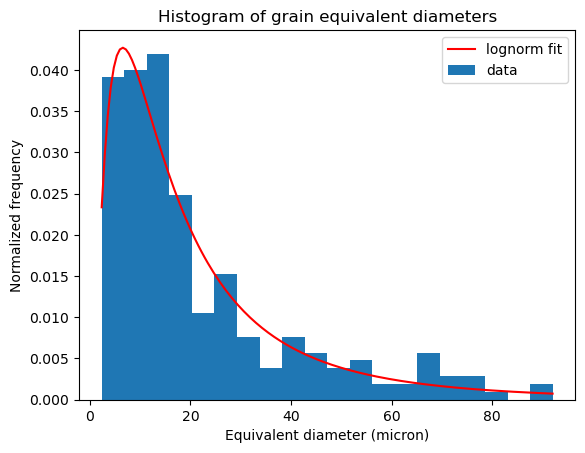

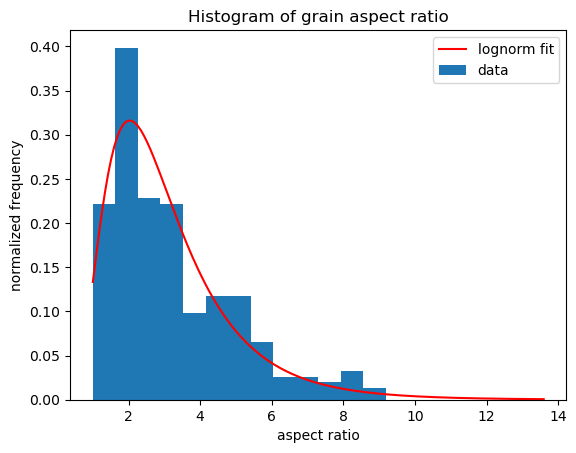

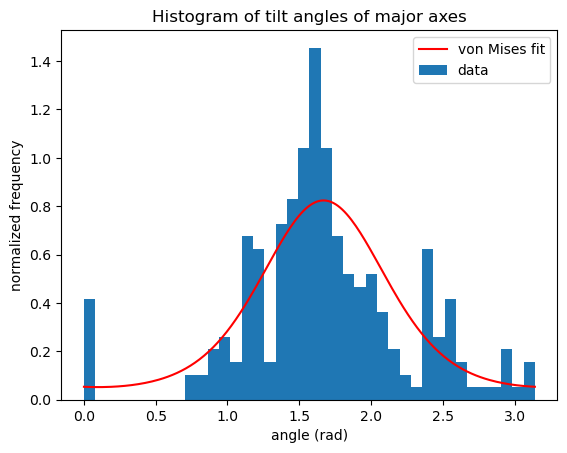

Analyzed microstructure of phase #0 (Iron fcc) with 245 grains.
Median values: equiv. diameter: 15.492 micron, aspect ratio: 2.71, tilt angle: 11.298°
Std. dev: equivalent diameter: 0.928 micron, aspect ratio: 0.538, tilt angle: 62.621°


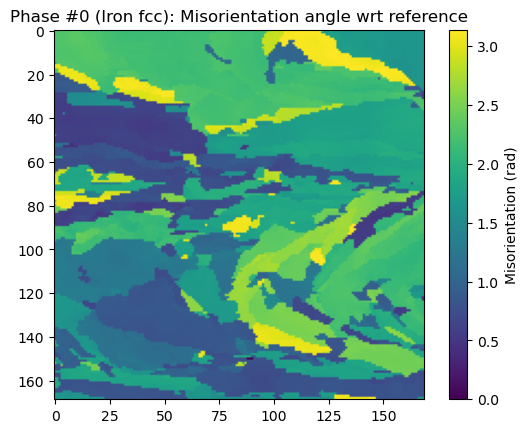

/mnt/c/Users/youse/kanapy/src/kanapy/texture.py:1371: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


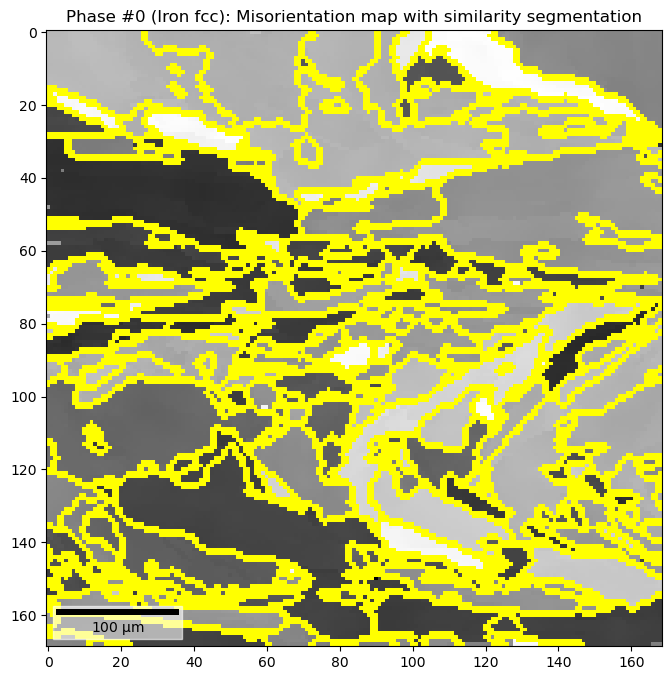

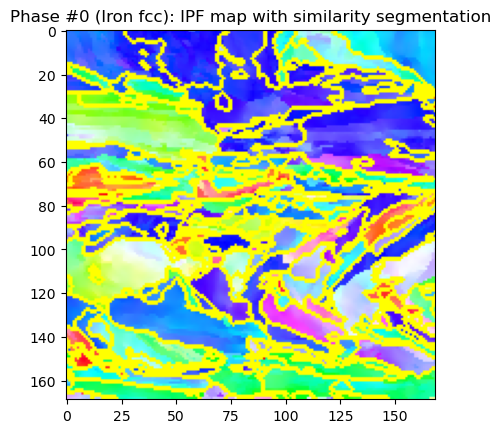

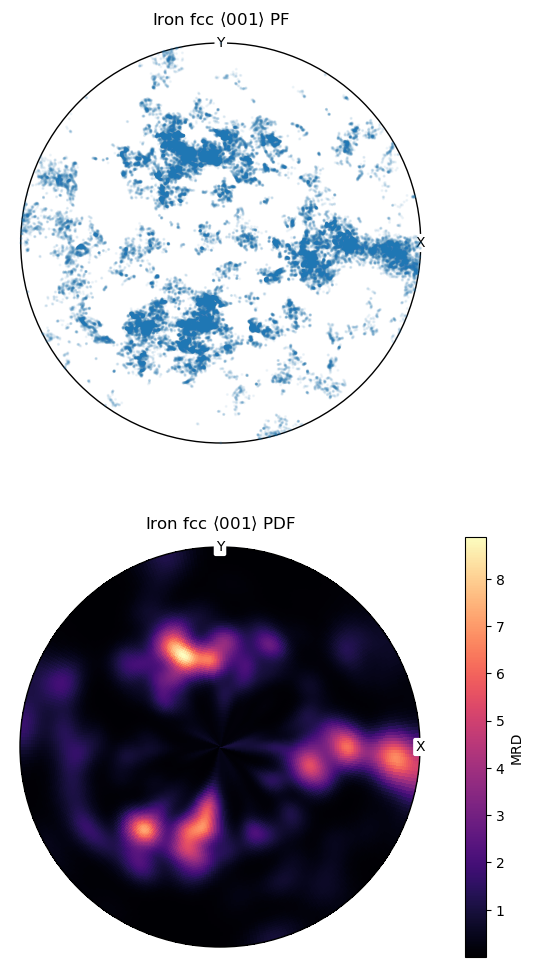

Step 2 completed: EBSD map loaded from ebsd_316L_500x500.ang
######################################################################################




########################################################################################
Step 3: Extracting microstructure statistics .........................................



Step 3 completed: Microstructure statistics extracted................................
#####################################################################################




########################################################################################
Step 4: Generating RVE ...............................................................



Creating an RVE based on user defined statistics
    Analyzed statistical data for phase iron_fcc (0)
    Total number of particles  = 6
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (15, 15, 15) (um)
    Number of voxels (X, Y, Z) = (15, 15, 15)
    Voxel resolution (X, Y, Z) = [1. 1. 1.](um)
    Total

100%|████████████████████████████████████████████████████████████████████████| 1441/1441 [00:05<00:00, 254.82it/s]


Actual final volume of ellipsoids: 1832.2211003306522
Completed particle packing
21 overlapping particles detected after packing
Kinetic energy of particles after packing: 10182.928756911362






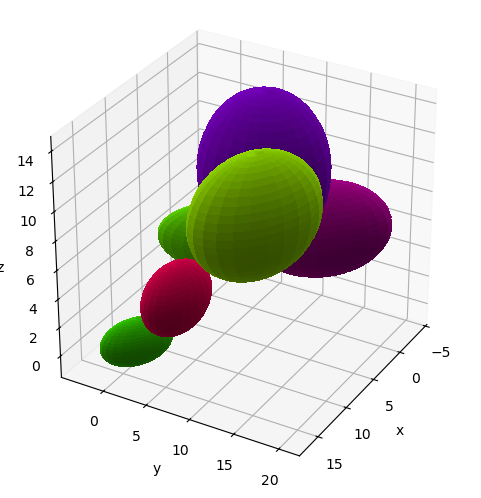

    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|████████████████████████████████████████████████████████████████████| 3375/3375 [00:00<00:00, 2166147.82it/s]


Completed RVE voxelization






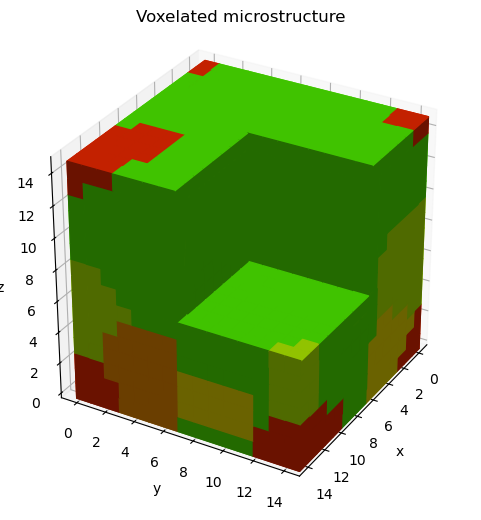

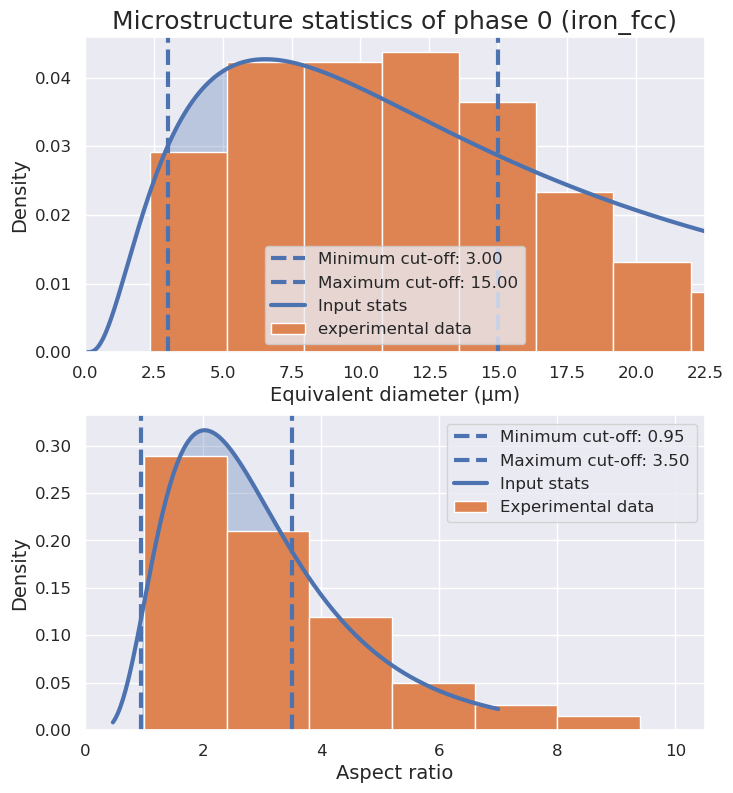

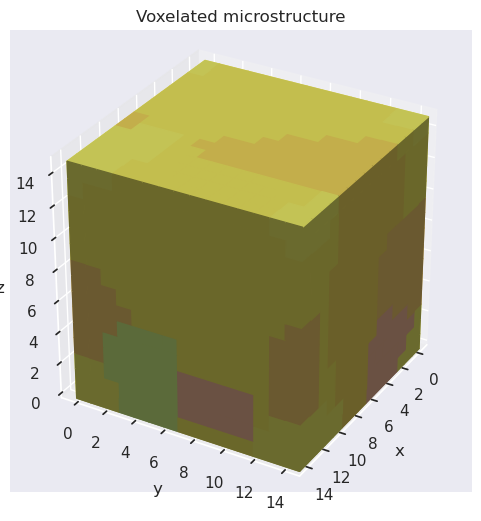

Step 4 completed: RVE generated.......................................................
######################################################################################




########################################################################################
Step 5: Exporting data ...............................................................



Saved to: /home/yousef/damaskWorkflows/ebsd2kanapy2damask/Version11/data/data_schema_damask.json
Step 5 completed: data saved in JSON file.............................................
######################################################################################




########################################################################################
Step 6: Building grid/material/load from JSON ........................................



cells:  15 × 15 × 15
size:   15.0 × 15.0 × 15.0 m³
origin: 0.0   0.0   0.0 m
# materials: 6



homogenization:
  direct:
    N_constituents: 1
    mechanical: {type: pass}
phase: {'0': null

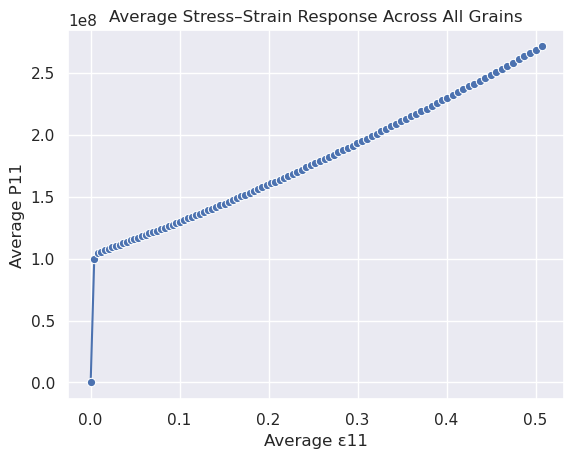

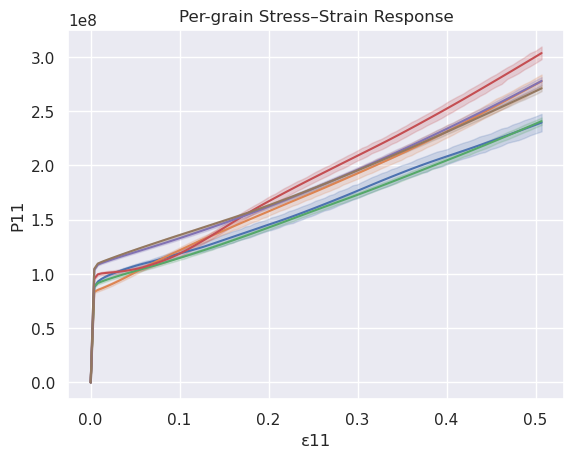

##################################################################################################
Step 8 completed: End of postprocessing ........................................................



########################################################################################
Step 9: updating json data file ......................................................



pick_idxs: [50, 100]
selected: ['increment_50', 'increment_100']
time_values: [25.0, 50.0]



Step 9 completed: End of updating ..............................................................
##################################################################################################



#####################################################################################################
Step 11: start remapping to data file .............................................................



old size of voxel in each direction: [1. 1. 1.]
old size of RVE in each direction: [15. 15. 15.]
old number of voxels in eac

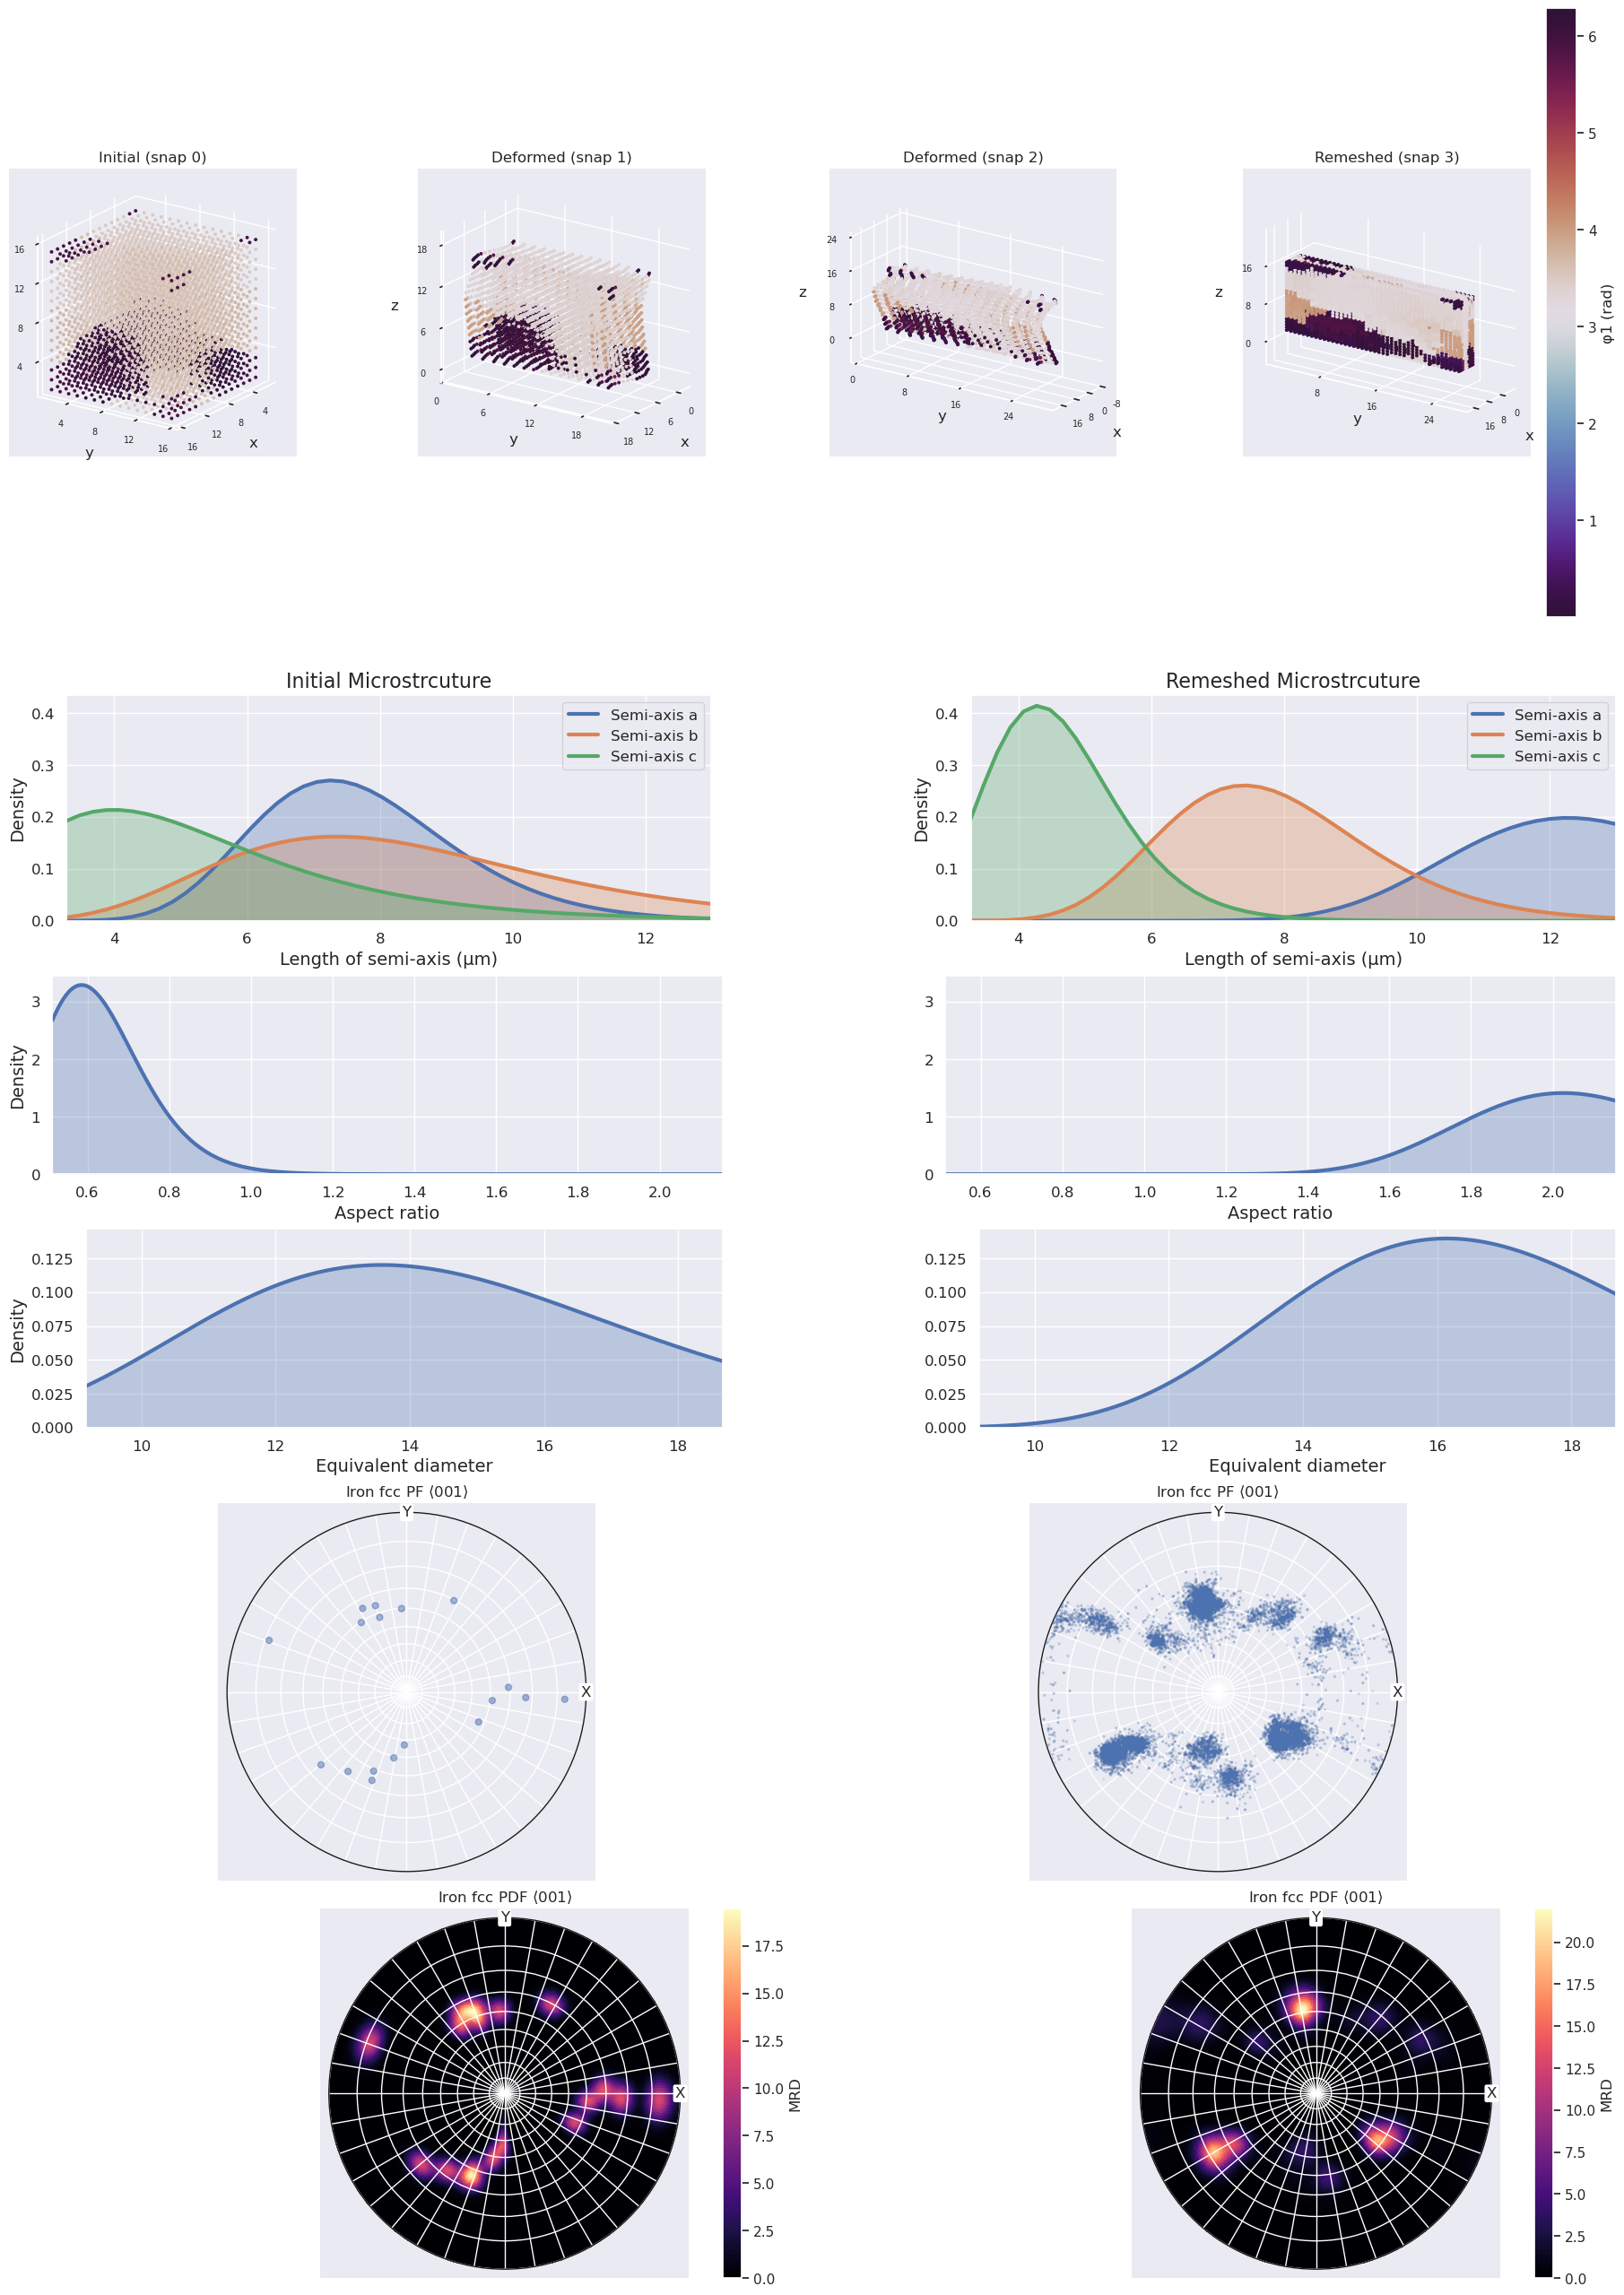

Step 14 completed: End of comparing ............................................................
##################################################################################################



Workflow completed successfully. Json file has been generated.


In [18]:
try:
    wf.run() # Run the workflow
    print("Workflow completed successfully. Json file has been generated.")
except Exception as e:
    print(f"An error occurred during the workflow execution: {str(e)}")

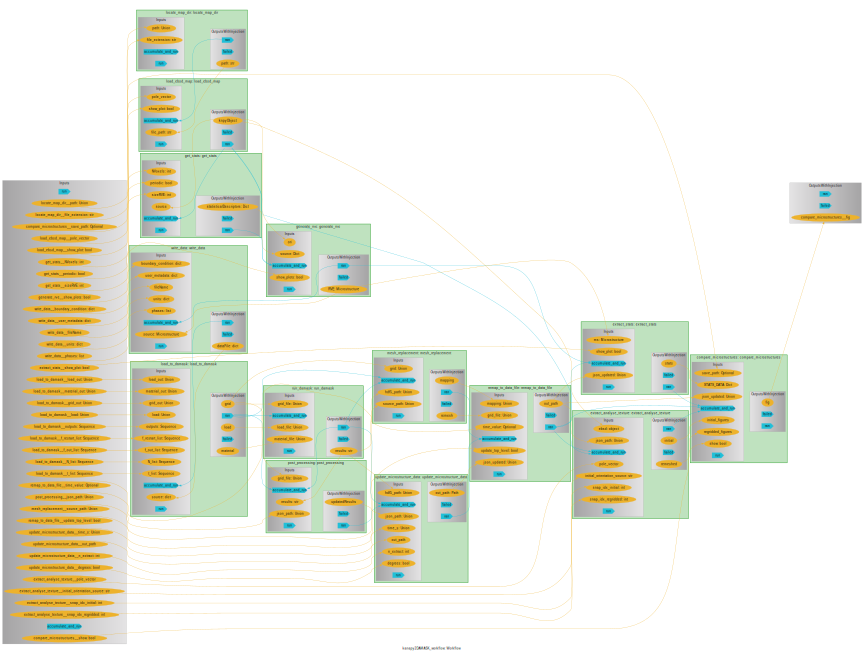

In [19]:
# Visualise the Kanapy→DAMASK workflow as a node graph
# (shows all steps, inputs, and dependencies at a glance)
wf.draw(size=(12,10)) 

In [20]:
# Draw the workflow graph at larger size and capture the Graphviz object
workflow_graph = wf.draw(size=(15,15))

# Increase the resolution of the rendered figure
workflow_graph.graph_attr.update({'dpi': '600'}) 

# Ensure output directory for figures exists
outdir = Path("figures")
outdir.mkdir(exist_ok=True) 

# Base name (without extension) for the workflow diagram
outfile = outdir.joinpath("Kanapy2Damask Workflow")

# Render the workflow graph to a high-resolution PNG file
workflow_graph.render(filename=outfile, format="png")

'figures/Kanapy2Damask Workflow.png'

### <font style="font-family:roboto;color:#455e6c"> Conclusion </font>

This workflow demonstrates that a unified data schema can seamlessly connect Kanapy and DAMASK into a single, interoperable pipeline, enabling smooth data exchange, and FAIR-compliant 4D microstructure evolution datasets. Key takeaways:

- A unified schema eliminates incompatibilities between tools, allowing direct transfer of geometry, field data, and metadata.
- 2D characterization data is reconstructed in Kanapy into statistically equivalent 3D RVEs.
- These RVEs are exported—using the common schema—to the crystal-plasticity FFT solver for mechanical and microstructure evolution simulation.
- Simulation outputs are automatically remapped back into the Kanapy using the FAIR data object.
- The workflow integrates statistical descriptors, texture evolution, and remeshing results into a coherent, traceable 4D dataset aligned with FAIR principles.

Overall, the workflow establishes a continuous digital thread from microstructure reconstruction to property prediction, enabling reproducible and extensible multi-tool microstructure evolution studies.

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c;text-align:justify"> <a href="https://github.com/ICAMS/Kanapy">Kanapy</a> | <a href="https://damask-multiphysics.org/">DAMASK</a> | <a href="https://github.com/pyiron/pyiron_workflow">Pyiron_workflow</a>| <a href="https://nfdi-matwerk.de/">NFDI MatWerk</a> </font> </br>
</div>

### Guide to produced folders

<pre>
damaskfiles/
    |___ VTK files                — field outputs from the DAMASK simulation (per increment)
    |___ vtk_restart              — VTK file of the remapped last increment on a regular mesh
    |___ results.hdf5             — full DAMASK results in HDF5 format
    |___ grid.vti                 — geometry file
    |___ load.yaml                — loading conditions
    |___ material.yaml            — material definitions
    |___ run.log                  — terminal output of the DAMASK run (solver progress, warnings)

data/
    |___ initial_stats.txt        — statistics of the initial microstructure
    |___ remeshed_stats.txt       — statistics of the remeshed microstructure
    |___ *.json                   — unified-schema files with metadata, mechanical fields,
                                     and voxel/grain-level microstructural data

figures/
    |___ compare_microstructures.png      — comparison plots of initial vs. remeshed microstructure
    |___ Kanapy2Damask Workflow.png       — workflow diagram
    |___ stress_strain_per_grain.png      — per-grain stress–strain response
    |___ stress_strain.png                — overall stress–strain curve
</pre>